In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import torch
import sys, os, gc
import numpy as np, pandas as pd, itertools
import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

current_path = rf"{os.getcwd()}"
main_path = os.path.abspath(os.path.dirname(current_path))
sys.path.append(rf"{main_path}")
sys.path.append(rf"{main_path}/src")

import utilities as util
import baysian_ntk_utils as bays_util

torch.cuda.is_available()

c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-25 12:14:36,393 - c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-11-25 12:14:36,453 - c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


True

# Setup

In [4]:
main_path
DATASET = "CMS_HCAL"
rbx_id = "HEP07"
fig_dirpath = rf"{main_path}/results/"
datafilename = f"{DATASET}/causal_data/"
data_dirpath = rf"{main_path}/data/{DATASET}"
util.Path(rf"{fig_dirpath}/{datafilename}").mkdir(exist_ok=True, parents=True)

tObj = util.ProcTimer()
sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 1.})

def set_binary_ax_lims(ax):
    for ax_sub in ax:
     _ = ax_sub.set_yticks([0, 1])

'c:\\Users\\mulugetawa\\OneDrive - Universitetet i Agder\\CERN\\InductionProject\\AnomalyCD'

# Load Sensor Data

In [5]:
# timewindow = ["01-08-2022", "31-12-2022"]

lhc_phy_run_dates = [["2022-08-04 08:00:00", "2022-08-23 19:00:00"],  # hcal starts from aug 23
                     ["2022-09-27 08:00:00", "2022-10-17 07:00:00"],
                     ["2022-10-19 08:00:00", "2022-11-05 07:00:00"],
                      ["2022-11-12 08:00:00", "2022-11-17 11:00:00"],
                      ["2022-11-19 12:00:00", "2022-11-22 19:00:00"],
                     ["2022-11-23 12:00:00", "2022-11-28 05:00:00"]
                     ]

# sensor_notation_map = {'QIECARD__1-B_SHT_RH_F': 'Q1H', 'QIECARD__1-B_SHT_TEMP_F': 'Q1T', 
#                         'QIECARD__2-B_SHT_RH_F': 'Q2H', 'QIECARD__2-B_SHT_TEMP_F': 'Q2T',
#                        'QIECARD__3-B_SHT_RH_F': 'Q3H', 'QIECARD__3-B_SHT_TEMP_F': 'Q3T', 
#                        'QIECARD__4-B_SHT_RH_F': 'Q4H', 'QIECARD__4-B_SHT_TEMP_F': 'Q4T',
#                        'SIPM__PELTIERCURRENT_F': 'SPC', 'SIPM__PELTIERVOLTAGE_F': 'SPV', 
#                        'SIPM__HUMIDITYS_F': 'SCH', 'SIPM__RTDTEMPERATURE_F': 'SRT'}

In [6]:
df_raw_hep07_rbx_rm_all = util.load_csv(f"{rbx_id}_RM_1_2_3_4_raw_ts_data.csv", filepath=data_dirpath, index_col=0)
df_raw_hep07_rbx_rm_all.index = pd.to_datetime(df_raw_hep07_rbx_rm_all.index)
df_raw_hep07_rbx_rm_all.loc[~df_raw_hep07_rbx_rm_all.iloc[:, 0].isna()].head()
df_raw_hep07_rbx_rm_all.shape

df_raw_hep07_rbx_rm_all.shape
for rbxrm_sysid in df_raw_hep07_rbx_rm_all["RBX_RM"].unique():
    rbxrm_sysid, df_raw_hep07_rbx_rm_all.loc[df_raw_hep07_rbx_rm_all["RBX_RM"]==rbxrm_sysid].shape

,SCH,SPC,SPV,SRT,Q1H,Q1T,Q2H,Q2T,Q3H,Q3T,Q4H,Q4T,RBX_RM
t,,,,,,,,,,,,,
2022-08-04 13:00:00,5.72083,0.52076,2.6337,4.99298,18.83317,29.57766,18.70343,30.02452,18.87890,30.16034,19.06203,29.51333,HEP07_1
2022-08-04 13:01:00,5.72083,0.52076,2.6337,4.99298,18.83327,29.57757,18.70348,30.02439,18.87900,30.16023,19.06208,29.51324,HEP07_1
2022-08-04 13:02:00,5.72083,0.52076,2.6337,4.99298,18.83336,29.57748,18.70353,30.02425,18.87909,30.16012,19.06213,29.51315,HEP07_1
2022-08-04 13:03:00,5.72083,0.52076,2.6337,4.99298,18.83346,29.57739,18.70358,30.02412,18.87919,30.16000,19.06218,29.51306,HEP07_1
2022-08-04 13:04:00,5.72083,0.52076,2.6337,4.99298,18.83355,29.57730,18.70363,30.02398,18.87929,30.15989,19.06223,29.51297,HEP07_1


(399905, 13)

(399905, 13)

('HEP07_1', (99776, 13))

('HEP07_2', (100212, 13))

('HEP07_3', (99845, 13))

('HEP07_4', (100072, 13))

# OD

In [7]:
from online_tsad import OnlineTSAD

saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//CMS_HCAL/causal_data/CMS_HCAL_HEP07_od_ts_signal.jpg


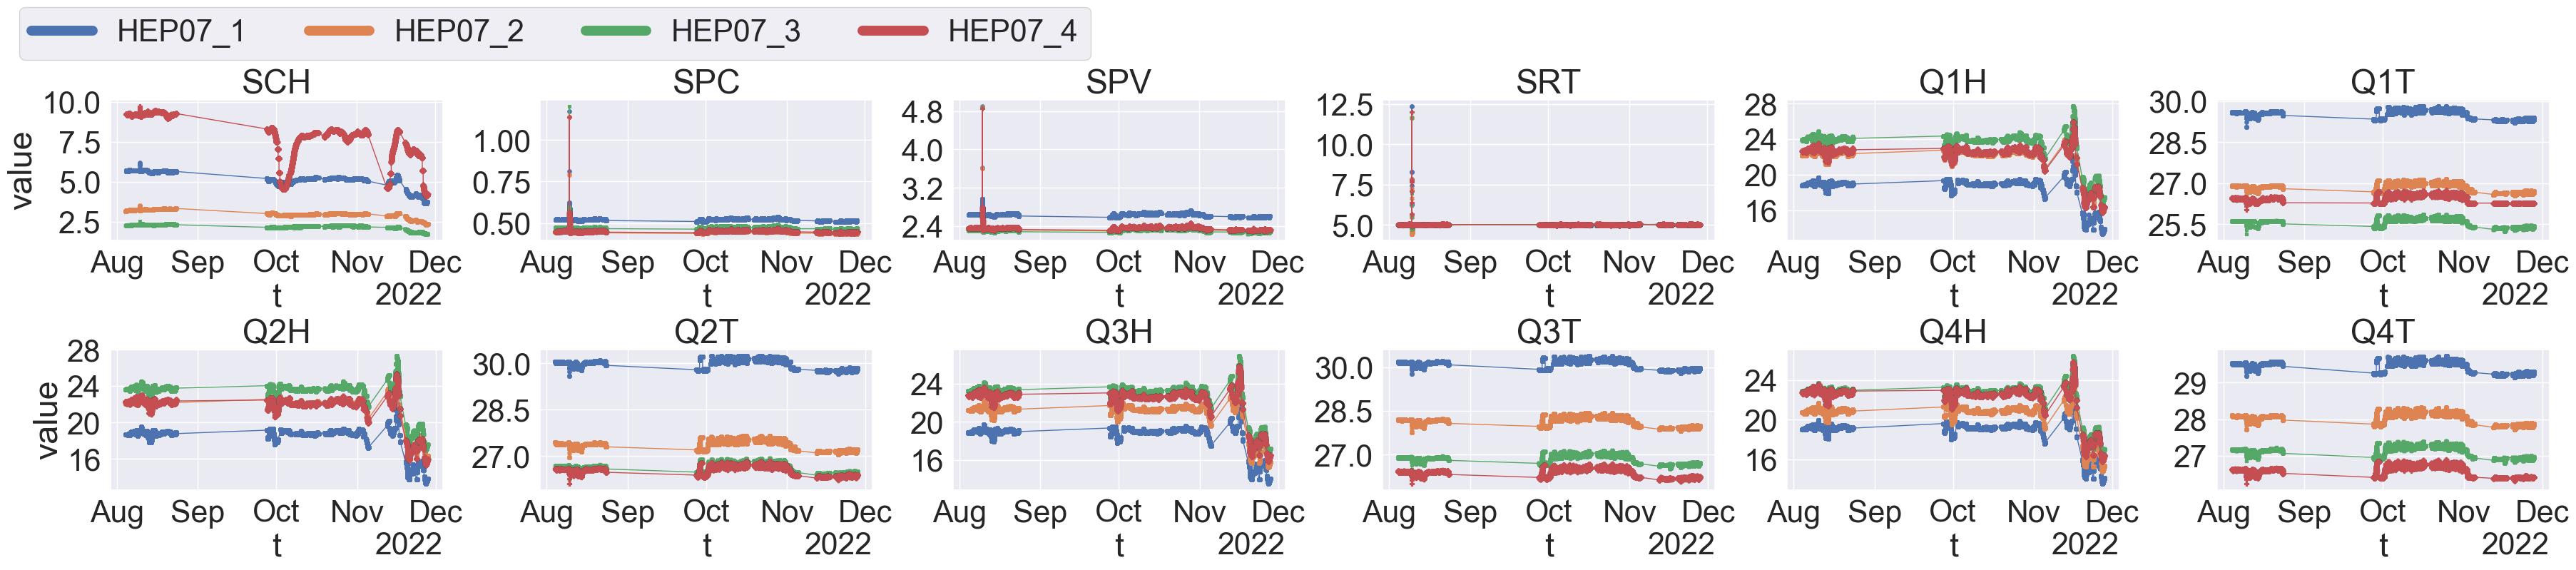

In [7]:
fig = OnlineTSAD.plot_ts_data_multi_system(df_raw_hep07_rbx_rm_all.iloc[:, :], system_col="RBX_RM", 
                                ncol=6, figsize=(6,3.5), 
                                hspace=1.0, wspace=0.25,
                                legendfontsize=12,
                                bbox_to_anchor=(0.0, 1.15)
                                )
util.save_figure(f"{datafilename}{DATASET}_{rbx_id}_od_ts_signal", fig, 
                 filepath=fig_dirpath, isshow=True, issave=True, dpi=100)

### Generated OD Flags

In [9]:
od_kwargs = dict(
                od_alg=["drift_tsd", "sr"],
                sr_th=35,
                sr_sampling_rate=12*2*60, # lower value sr_sampling_rate=12*1, and higher sr_th =11, detects freg changes
                score_window_size=12*4*60,
                series_window_size=6*4*60,
                sliding_window=24*4*60,
                sliding_min_period=6*60,
                issliding_window=True,  # for tsd
                sd_th=10,
                sd_zero_adjust_k=0.05,
                smoothing_kernel_size=0,
                trend_period=24*4*60,
                istrend_thr=5,
                drift_thr=20,
                clean_small_noises=False,
                isdropna=True,
                user_data_cp_idx = ["2022-09-27 08:00:00", "2022-10-19 08:00:00", "2022-11-12 08:00:00"],
                drift_score_smoothingfilter_window=0
            )

df_outlier_rm_all = []
for rbx_rm_id in df_raw_hep07_rbx_rm_all["RBX_RM"].unique():  
    print(rbx_rm_id)
    df_raw = df_raw_hep07_rbx_rm_all.loc[df_raw_hep07_rbx_rm_all["RBX_RM"] == rbx_rm_id, :]
    df_raw.drop(columns=["RBX_RM"], inplace=True)
    
    objODEngine = OnlineTSAD()
    df_outlier_rm, df_raw = objODEngine.inference(df_raw, **od_kwargs)
    # plot_dfs, marker_dfs, non_lbl_cols = objODEngine.prepare_plot_dfs(df_raw, df_outlier_rm, isfragment_flag_handle=True)
    df_outlier_rm["RBX_RM"] = rbx_rm_id
    df_outlier_rm_all.append(df_outlier_rm)

df_outlier_rm_hep07_rbx_rm_all = pd.concat(df_outlier_rm_all, axis=0)
df_outlier_rm_hep07_rbx_rm_all.head()
df_outlier_rm_hep07_rbx_rm_all.shape

HEP07_1
                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T
t                                                                                                                  
2022-08-01 01:35:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:36:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:37:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:38:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:39:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
data shape:  (99776, 12)
################################################################################
['drift_tsd', 'sr']...
ts outliers detection... drift_tsd
preparing normal

  0%|          | 0/12 [00:00<?, ?it/s]

trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
01_SCH
(99776, 1)
Nan records:  1578
(98198, 1)
detrended_med: 0.03186139713541669, istrend_thr: 5, istrend_thr_med: 0.15930698567708346
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0160695737184056, detrended_med: 0.03186139713541669
processing time: 0.1768205165863037 secs.
(99776, 7)
dropping 1578 nans...
(98198, 7)


  8%|▊         | 1/12 [00:00<00:02,  4.04it/s]

number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17869,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
02_SPC
(99776, 1)
Nan records:  1578
(98198, 1)
detrended_med: 0.002092237331260516, istrend_thr: 5, istrend_thr_med: 0.010461186656302579
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
drift_tol_sca

 17%|█▋        | 2/12 [00:00<00:02,  4.17it/s]

(99776, 7)
dropping 1578 nans...
(98198, 7)
(27721,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17869,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
03_SPV
(99776, 1)
Nan records:  1578
(98198, 1)


 25%|██▌       | 3/12 [00:00<00:02,  4.23it/s]

detrended_med: 0.009397096354166967, istrend_thr: 5, istrend_thr_med: 0.046985481770834836
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0160695737184056, detrended_med: 0.009397096354166967
processing time: 0.15902948379516602 secs.
(99776, 7)
dropping 1578 nans...
(98198, 7)
(27721,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17869,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 33%|███▎      | 4/12 [00:00<00:01,  4.26it/s]

detrended_med: 0.007568789930555209, istrend_thr: 5, istrend_thr_med: 0.03784394965277604
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0160695737184056, detrended_med: 0.007568789930555209
processing time: 0.15783262252807617 secs.
(99776, 7)
dropping 1578 nans...
(98198, 7)
(27721,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17869,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, '

 42%|████▏     | 5/12 [00:01<00:01,  4.25it/s]

detrended_med: 0.13283297135416738, istrend_thr: 5, istrend_thr_med: 0.6641648567708369
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.13283297135416738
processing time: 0.1578514575958252 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user

 50%|█████     | 6/12 [00:01<00:01,  4.28it/s]

detrended_med: 0.03477888671874929, istrend_thr: 5, istrend_thr_med: 0.17389443359374646
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.03477888671874929
processing time: 0.1544961929321289 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 58%|█████▊    | 7/12 [00:01<00:01,  4.29it/s]

detrended_med: 0.12469789713541424, istrend_thr: 5, istrend_thr_med: 0.6234894856770712
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.12469789713541424
processing time: 0.1581897735595703 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user

 67%|██████▋   | 8/12 [00:01<00:00,  4.29it/s]

detrended_med: 0.03605717664931163, istrend_thr: 5, istrend_thr_med: 0.18028588324655814
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.03605717664931163
processing time: 0.15970706939697266 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'us

 75%|███████▌  | 9/12 [00:02<00:00,  4.29it/s]

detrended_med: 0.12636419270833343, istrend_thr: 5, istrend_thr_med: 0.6318209635416672
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.12636419270833343
processing time: 0.1576995849609375 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user

 83%|████████▎ | 10/12 [00:02<00:00,  4.33it/s]

detrended_med: 0.032754951954553135, istrend_thr: 5, istrend_thr_med: 0.16377475977276568
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.032754951954553135
processing time: 0.1545088291168213 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'u

 92%|█████████▏| 11/12 [00:02<00:00,  4.41it/s]

detrended_med: 0.12847151302083049, istrend_thr: 5, istrend_thr_med: 0.6423575651041524
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.12847151302083049
processing time: 0.1489391326904297 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user

100%|██████████| 12/12 [00:02<00:00,  4.30it/s]


detrended_med: 0.032676544251863504, istrend_thr: 5, istrend_thr_med: 0.16338272125931752
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0425260694209348, detrended_med: 0.032676544251863504
processing time: 0.15265464782714844 secs.
(99776, 7)
dropping 4070 nans...
(95706, 7)
(27975,)
number time-windows with std=0:  0
(27400,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16754,)
number time-windows with std=0:  0


100%|██████████| 24/24 [00:00<00:00, 1708.01it/s]


0    99770
1        6
Name: 01_SCH_OL_LBL, dtype: int64
0    90567
1     9209
Name: 01_SCH_DRIFT_OL_LBL, dtype: int64
0    99739
1       37
Name: 02_SPC_OL_LBL, dtype: int64
0    99776
Name: 02_SPC_DRIFT_OL_LBL, dtype: int64
0    99774
1        2
Name: 03_SPV_OL_LBL, dtype: int64
0    99776
Name: 03_SPV_DRIFT_OL_LBL, dtype: int64
0    99769
1        7
Name: 04_SRT_OL_LBL, dtype: int64
0    99776
Name: 04_SRT_DRIFT_OL_LBL, dtype: int64
0    99772
1        4
Name: 05_Q1H_OL_LBL, dtype: int64
0    90348
1     9428
Name: 05_Q1H_DRIFT_OL_LBL, dtype: int64
0    99760
1       16
Name: 06_Q1T_OL_LBL, dtype: int64
0    99776
Name: 06_Q1T_DRIFT_OL_LBL, dtype: int64
0    99771
1        5
Name: 07_Q2H_OL_LBL, dtype: int64
0    90272
1     9504
Name: 07_Q2H_DRIFT_OL_LBL, dtype: int64
0    99759
1       17
Name: 08_Q2T_OL_LBL, dtype: int64
0    99776
Name: 08_Q2T_DRIFT_OL_LBL, dtype: int64
0    99772
1        4
Name: 09_Q3H_OL_LBL, dtype: int64
0    90292
1     9484
Name: 09_Q3H_DRIFT_OL_LBL, dtype:

 17%|█▋        | 2/12 [00:00<00:00, 16.74it/s]

(99776, 1)
dropping 1578 nans...
(98198, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
2022-11-27 23:02:00 2022-11-27T23:02:00.000000000
(99776, 1)
dropping 1578 nans...
(98198, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
2022-11-27 23:02:00 2022-11-27T23:02:00.000000000
(99776, 1)
dropping 1578 nans...
(98198, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
2022-11-27 23:02:00 2022-11-27T23:02:00.000000000
(99776, 1)
dropping 1578 nans...
(98198, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000


 50%|█████     | 6/12 [00:00<00:00, 17.36it/s]

2022-11-12 08:00:00 2022-11-12T13:13:00.000000000
2022-11-27 23:02:00 2022-11-27T23:02:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000


 67%|██████▋   | 8/12 [00:00<00:00, 17.64it/s]

2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


 83%|████████▎ | 10/12 [00:00<00:00, 18.24it/s]

(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99776, 1)
dropping 4070 nans...
(95706, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000


100%|██████████| 12/12 [00:00<00:00, 18.04it/s]


2022-11-12 08:00:00 2022-11-12T09:37:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


100%|██████████| 12/12 [00:00<00:00, 1840.55it/s]


0    99774
1        2
Name: 01_SCH_OL_LBL, dtype: int64
0    99773
1        3
Name: 02_SPC_OL_LBL, dtype: int64
0    99773
1        3
Name: 03_SPV_OL_LBL, dtype: int64
0    99752
1       24
Name: 04_SRT_OL_LBL, dtype: int64
0    99776
Name: 05_Q1H_OL_LBL, dtype: int64
0    99771
1        5
Name: 06_Q1T_OL_LBL, dtype: int64
0    99776
Name: 07_Q2H_OL_LBL, dtype: int64
0    99773
1        3
Name: 08_Q2T_OL_LBL, dtype: int64
0    99776
Name: 09_Q3H_OL_LBL, dtype: int64
0    99773
1        3
Name: 10_Q3T_OL_LBL, dtype: int64
0    99776
Name: 11_Q4H_OL_LBL, dtype: int64
0    99773
1        3
Name: 12_Q4T_OL_LBL, dtype: int64
missing data (after outlier cleaning): (5228, 12)
Number of missing data in df_outlier: 
0     94548
8      3650
4      1158
12      420
dtype: int64
Number of OD flags in df_outlier: 
01_SCH_OL_LBL     2
02_SPC_OL_LBL     3
03_SPV_OL_LBL     3
04_SRT_OL_LBL    24
05_Q1H_OL_LBL     0
06_Q1T_OL_LBL     5
07_Q2H_OL_LBL     0
08_Q2T_OL_LBL     3
09_Q3H_OL_LBL     0
10_Q3T_

  0%|          | 0/12 [00:00<?, ?it/s]

['DRIFT_TSD__01_SCH_OL_LBL', 'DRIFT_TSD__01_SCH_DRIFT_OL_LBL', 'SR__01_SCH_OL_LBL']
0    90561
1     9213
2        2
Name: 01_SCH_OL_LBL, dtype: int64
['DRIFT_TSD__02_SPC_OL_LBL', 'DRIFT_TSD__02_SPC_DRIFT_OL_LBL', 'SR__02_SPC_OL_LBL']
0    99739
1       34
2        3
Name: 02_SPC_OL_LBL, dtype: int64
['DRIFT_TSD__03_SPV_OL_LBL', 'DRIFT_TSD__03_SPV_DRIFT_OL_LBL', 'SR__03_SPV_OL_LBL']


 33%|███▎      | 4/12 [00:00<00:00, 38.36it/s]

0    99773
2        2
1        1
Name: 03_SPV_OL_LBL, dtype: int64
['DRIFT_TSD__04_SRT_OL_LBL', 'DRIFT_TSD__04_SRT_DRIFT_OL_LBL', 'SR__04_SRT_OL_LBL']
0    99751
1       19
2        6
Name: 04_SRT_OL_LBL, dtype: int64
['DRIFT_TSD__05_Q1H_OL_LBL', 'DRIFT_TSD__05_Q1H_DRIFT_OL_LBL', 'SR__05_Q1H_OL_LBL']
0    90344
1     9432
Name: 05_Q1H_OL_LBL, dtype: int64
['DRIFT_TSD__06_Q1T_OL_LBL', 'DRIFT_TSD__06_Q1T_DRIFT_OL_LBL', 'SR__06_Q1T_OL_LBL']
0    99757
1       17
2        2
Name: 06_Q1T_OL_LBL, dtype: int64
['DRIFT_TSD__07_Q2H_OL_LBL', 'DRIFT_TSD__07_Q2H_DRIFT_OL_LBL', 'SR__07_Q2H_OL_LBL']


 75%|███████▌  | 9/12 [00:00<00:00, 43.22it/s]

0    90267
1     9509
Name: 07_Q2H_OL_LBL, dtype: int64
['DRIFT_TSD__08_Q2T_OL_LBL', 'DRIFT_TSD__08_Q2T_DRIFT_OL_LBL', 'SR__08_Q2T_OL_LBL']
0    99758
1       16
2        2
Name: 08_Q2T_OL_LBL, dtype: int64
['DRIFT_TSD__09_Q3H_OL_LBL', 'DRIFT_TSD__09_Q3H_DRIFT_OL_LBL', 'SR__09_Q3H_OL_LBL']
0    90288
1     9488
Name: 09_Q3H_OL_LBL, dtype: int64


100%|██████████| 12/12 [00:00<00:00, 42.32it/s]

['DRIFT_TSD__10_Q3T_OL_LBL', 'DRIFT_TSD__10_Q3T_DRIFT_OL_LBL', 'SR__10_Q3T_OL_LBL']
0    99757
1       18
2        1
Name: 10_Q3T_OL_LBL, dtype: int64
['DRIFT_TSD__11_Q4H_OL_LBL', 'DRIFT_TSD__11_Q4H_DRIFT_OL_LBL', 'SR__11_Q4H_OL_LBL']
0    90224
1     9552
Name: 11_Q4H_OL_LBL, dtype: int64
['DRIFT_TSD__12_Q4T_OL_LBL', 'DRIFT_TSD__12_Q4T_DRIFT_OL_LBL', 'SR__12_Q4T_OL_LBL']
0    99757
1       18
2        1
Name: 12_Q4T_OL_LBL, dtype: int64


                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T  DRIFT_TSD__01_SCH_TREND  DRIFT_TSD__01_SCH_OL_SCORE  DRIFT_TSD__01_SCH_DRIFT_OL_SCORE  DRIFT_TSD__02_SPC_TREND  DRIFT_TSD__02_SPC_OL_SCORE  DRIFT_TSD__02_SPC_DRIFT_OL_SCORE  DRIFT_TSD__03_SPV_TREND  DRIFT_TSD__03_SPV_OL_SCORE  DRIFT_TSD__03_SPV_DRIFT_OL_SCORE  DRIFT_TSD__04_SRT_TREND  DRIFT_TSD__04_SRT_OL_SCORE  DRIFT_TSD__04_SRT_DRIFT_OL_SCORE  DRIFT_TSD__05_Q1H_TREND  DRIFT_TSD__05_Q1H_OL_SCORE  DRIFT_TSD__05_Q1H_DRIFT_OL_SCORE  DRIFT_TSD__06_Q1T_TREND  DRIFT_TSD__06_Q1T_OL_SCORE  DRIFT_TSD__06_Q1T_DRIFT_OL_SCORE  DRIFT_TSD__07_Q2H_TREND  DRIFT_TSD__07_Q2H_OL_SCORE  DRIFT_TSD__07_Q2H_DRIFT_OL_SCORE  DRIFT_TSD__08_Q2T_TREND  DRIFT_TSD__08_Q2T_OL_SCORE  DRIFT_TSD__08_Q2T_DRIFT_OL_SCORE  DRIFT_TSD__09_Q3H_TREND  DRIFT_TSD__09_Q3H_OL_SCORE  DRIFT_TSD__09_Q3H_DRIFT_OL_SCORE  DRIFT_TSD__10_Q3T_TREND  DRIFT_TSD__10_Q3T_OL_SCORE  DRIFT_TSD__10_Q3T_DRIFT_OL_SCORE  \
t          

  0%|          | 0/12 [00:00<?, ?it/s]

['01_SCH_OL_LBL']
01_SCH: num_outlier: 9215
['02_SPC_OL_LBL']


 17%|█▋        | 2/12 [00:00<00:00, 15.50it/s]

02_SPC: num_outlier: 37
['03_SPV_OL_LBL']
03_SPV: num_outlier: 3
['04_SRT_OL_LBL']


 42%|████▏     | 5/12 [00:00<00:00, 20.02it/s]

04_SRT: num_outlier: 25
['05_Q1H_OL_LBL']
05_Q1H: num_outlier: 9432
['06_Q1T_OL_LBL']
06_Q1T: num_outlier: 19
['07_Q2H_OL_LBL']


 67%|██████▋   | 8/12 [00:00<00:00, 23.80it/s]

07_Q2H: num_outlier: 9509
['08_Q2T_OL_LBL']
08_Q2T: num_outlier: 18
['09_Q3H_OL_LBL']
09_Q3H: num_outlier: 9488
['10_Q3T_OL_LBL']
10_Q3T: num_outlier: 19
['11_Q4H_OL_LBL']
11_Q4H: num_outlier: 9552


100%|██████████| 12/12 [00:00<00:00, 26.75it/s]

['12_Q4T_OL_LBL']
12_Q4T: num_outlier: 19


process time: 4.364614725112915 seconds.
HEP07_2
                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T
t                                                                                                                  
2022-08-01 01:35:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:36:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:37:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:38:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:39:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
data shape:  (100212, 12)
################################################################################
['drift_tsd', 'sr']...
ts outlie

  0%|          | 0/12 [00:00<?, ?it/s]

trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
01_SCH
(100212, 1)
Nan records:  908
(99304, 1)
detrended_med: 0.012401265190972177, istrend_thr: 5, istrend_thr_med: 0.062006325954860886
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0091436397325384, detrended_med: 0.012401265190972177
processing time: 0.1522235870361328 secs.
(100212, 7)
dropping 908 nans...
(99304, 

  8%|▊         | 1/12 [00:00<00:02,  4.32it/s]

number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18630,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
02_SPC
(100212, 1)
Nan records:  908
(99304, 1)


 17%|█▋        | 2/12 [00:00<00:02,  3.97it/s]

detrended_med: 0.00131573871527782, istrend_thr: 5, istrend_thr_med: 0.0065786935763891
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0091436397325384, detrended_med: 0.00131573871527782
processing time: 0.18870329856872559 secs.
(100212, 7)
dropping 908 nans...
(99304, 7)
(28021,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18630,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]

detrended_med: 0.006596138020833475, istrend_thr: 5, istrend_thr_med: 0.032980690104167376
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0091436397325384, detrended_med: 0.006596138020833475
processing time: 0.1730661392211914 secs.
(100212, 7)
dropping 908 nans...
(99304, 7)
(28021,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18630,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, '

 33%|███▎      | 4/12 [00:00<00:01,  4.10it/s]

detrended_med: 0.008919056423611682, istrend_thr: 5, istrend_thr_med: 0.04459528211805841
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0091436397325384, detrended_med: 0.008919056423611682
processing time: 0.1560678482055664 secs.
(100212, 7)
dropping 908 nans...
(99304, 7)
(28021,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18630,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'u

 42%|████▏     | 5/12 [00:01<00:01,  4.00it/s]

detrended_med: 0.14639090017361056, istrend_thr: 5, istrend_thr_med: 0.7319545008680528
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.14639090017361056
processing time: 0.1864159107208252 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 50%|█████     | 6/12 [00:01<00:01,  4.01it/s]

detrended_med: 0.03164458420139127, istrend_thr: 5, istrend_thr_med: 0.15822292100695634
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.03164458420139127
processing time: 0.16632342338562012 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'u

 58%|█████▊    | 7/12 [00:01<00:01,  3.87it/s]

detrended_med: 0.13529484288194382, istrend_thr: 5, istrend_thr_med: 0.6764742144097191
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.13529484288194382
processing time: 0.1954972743988037 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 67%|██████▋   | 8/12 [00:02<00:01,  3.93it/s]

detrended_med: 0.031050907118050475, istrend_thr: 5, istrend_thr_med: 0.15525453559025237
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.031050907118050475
processing time: 0.16956186294555664 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 75%|███████▌  | 9/12 [00:02<00:00,  4.06it/s]

detrended_med: 0.1381414375000034, istrend_thr: 5, istrend_thr_med: 0.690707187500017
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.1381414375000034
processing time: 0.15775847434997559 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_

 83%|████████▎ | 10/12 [00:02<00:00,  4.08it/s]

detrended_med: 0.03095778993055731, istrend_thr: 5, istrend_thr_med: 0.15478894965278656
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.03095778993055731
processing time: 0.16420316696166992 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'u

 92%|█████████▏| 11/12 [00:02<00:00,  4.01it/s]

detrended_med: 0.1450835208333352, istrend_thr: 5, istrend_thr_med: 0.725417604166676
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.1450835208333352
processing time: 0.16753506660461426 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_

100%|██████████| 12/12 [00:02<00:00,  4.01it/s]


detrended_med: 0.031400889756938, istrend_thr: 5, istrend_thr_med: 0.15700444878469
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0461525613053417, detrended_med: 0.031400889756938
processing time: 0.16649580001831055 secs.
(100212, 7)
dropping 4421 nans...
(95791, 7)
(27245,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23991,)
number time-windows with std=0:  0
(16058,)
number time-windows with std=0:  0


100%|██████████| 24/24 [00:00<00:00, 1823.97it/s]


0    100206
1         6
Name: 01_SCH_OL_LBL, dtype: int64
0    84576
1    15636
Name: 01_SCH_DRIFT_OL_LBL, dtype: int64
0    100209
1         3
Name: 02_SPC_OL_LBL, dtype: int64
0    100212
Name: 02_SPC_DRIFT_OL_LBL, dtype: int64
0    100210
1         2
Name: 03_SPV_OL_LBL, dtype: int64
0    100212
Name: 03_SPV_DRIFT_OL_LBL, dtype: int64
0    100205
1         7
Name: 04_SRT_OL_LBL, dtype: int64
0    100212
Name: 04_SRT_DRIFT_OL_LBL, dtype: int64
0    100208
1         4
Name: 05_Q1H_OL_LBL, dtype: int64
0    91075
1     9137
Name: 05_Q1H_DRIFT_OL_LBL, dtype: int64
0    100207
1         5
Name: 06_Q1T_OL_LBL, dtype: int64
0    100212
Name: 06_Q1T_DRIFT_OL_LBL, dtype: int64
0    100208
1         4
Name: 07_Q2H_OL_LBL, dtype: int64
0    90985
1     9227
Name: 07_Q2H_DRIFT_OL_LBL, dtype: int64
0    100207
1         5
Name: 08_Q2T_OL_LBL, dtype: int64
0    100212
Name: 08_Q2T_DRIFT_OL_LBL, dtype: int64
0    100208
1         4
Name: 09_Q3H_OL_LBL, dtype: int64
0    91154
1     9058
Name: 09_Q

 17%|█▋        | 2/12 [00:00<00:00, 15.62it/s]

(100212, 1)
dropping 908 nans...
(99304, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
2022-11-28 04:02:00 2022-11-28T04:02:00.000000000
(100212, 1)
dropping 908 nans...
(99304, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
2022-11-28 04:02:00 2022-11-28T04:02:00.000000000
(100212, 1)
dropping 908 nans...
(99304, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
2022-11-28 04:02:00 2022-11-28T04:02:00.000000000
(100212, 1)
dropping 908 nans...
(99304, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000


 33%|███▎      | 4/12 [00:00<00:00, 15.44it/s]

2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T11:34:00.000000000
2022-11-28 04:02:00 2022-11-28T04:02:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000


 50%|█████     | 6/12 [00:00<00:00, 15.55it/s]

2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000


 67%|██████▋   | 8/12 [00:00<00:00, 15.39it/s]

2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


 83%|████████▎ | 10/12 [00:00<00:00, 15.16it/s]

(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100212, 1)
dropping 4421 nans...
(95791, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000


100%|██████████| 12/12 [00:00<00:00, 15.24it/s]


2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


100%|██████████| 12/12 [00:00<00:00, 1497.70it/s]


0    100210
1         2
Name: 01_SCH_OL_LBL, dtype: int64
0    100205
1         7
Name: 02_SPC_OL_LBL, dtype: int64
0    100207
1         5
Name: 03_SPV_OL_LBL, dtype: int64
0    100195
1        17
Name: 04_SRT_OL_LBL, dtype: int64
0    100212
Name: 05_Q1H_OL_LBL, dtype: int64
0    100207
1         5
Name: 06_Q1T_OL_LBL, dtype: int64
0    100212
Name: 07_Q2H_OL_LBL, dtype: int64
0    100211
1         1
Name: 08_Q2T_OL_LBL, dtype: int64
0    100212
Name: 09_Q3H_OL_LBL, dtype: int64
0    100210
1         2
Name: 10_Q3T_OL_LBL, dtype: int64
0    100212
Name: 11_Q4H_OL_LBL, dtype: int64
0    100209
1         3
Name: 12_Q4T_OL_LBL, dtype: int64
missing data (after outlier cleaning): (4909, 12)
Number of missing data in df_outlier: 
0     95303
8      4001
4       488
12      420
dtype: int64
Number of OD flags in df_outlier: 
01_SCH_OL_LBL     2
02_SPC_OL_LBL     7
03_SPV_OL_LBL     5
04_SRT_OL_LBL    17
05_Q1H_OL_LBL     0
06_Q1T_OL_LBL     5
07_Q2H_OL_LBL     0
08_Q2T_OL_LBL     1
09_Q3H_

 33%|███▎      | 4/12 [00:00<00:00, 35.15it/s]

['DRIFT_TSD__01_SCH_OL_LBL', 'DRIFT_TSD__01_SCH_DRIFT_OL_LBL', 'SR__01_SCH_OL_LBL']
0    84569
1    15642
2        1
Name: 01_SCH_OL_LBL, dtype: int64
['DRIFT_TSD__02_SPC_OL_LBL', 'DRIFT_TSD__02_SPC_DRIFT_OL_LBL', 'SR__02_SPC_OL_LBL']
0    100205
1         4
2         3
Name: 02_SPC_OL_LBL, dtype: int64
['DRIFT_TSD__03_SPV_OL_LBL', 'DRIFT_TSD__03_SPV_DRIFT_OL_LBL', 'SR__03_SPV_OL_LBL']
0    100207
1         3
2         2
Name: 03_SPV_OL_LBL, dtype: int64
['DRIFT_TSD__04_SRT_OL_LBL', 'DRIFT_TSD__04_SRT_DRIFT_OL_LBL', 'SR__04_SRT_OL_LBL']
0    100193
1        14
2         5
Name: 04_SRT_OL_LBL, dtype: int64
['DRIFT_TSD__05_Q1H_OL_LBL', 'DRIFT_TSD__05_Q1H_DRIFT_OL_LBL', 'SR__05_Q1H_OL_LBL']
0    91071
1     9141
Name: 05_Q1H_OL_LBL, dtype: int64
['DRIFT_TSD__06_Q1T_OL_LBL', 'DRIFT_TSD__06_Q1T_DRIFT_OL_LBL', 'SR__06_Q1T_OL_LBL']
0    100204
1         6
2         2
Name: 06_Q1T_OL_LBL, dtype: int64
['DRIFT_TSD__07_Q2H_OL_LBL', 'DRIFT_TSD__07_Q2H_DRIFT_OL_LBL', 'SR__07_Q2H_OL_LBL']
0    9098

100%|██████████| 12/12 [00:00<00:00, 38.37it/s]

0    91150
1     9062
Name: 09_Q3H_OL_LBL, dtype: int64
['DRIFT_TSD__10_Q3T_OL_LBL', 'DRIFT_TSD__10_Q3T_DRIFT_OL_LBL', 'SR__10_Q3T_OL_LBL']
0    100207
1         3
2         2
Name: 10_Q3T_OL_LBL, dtype: int64
['DRIFT_TSD__11_Q4H_OL_LBL', 'DRIFT_TSD__11_Q4H_DRIFT_OL_LBL', 'SR__11_Q4H_OL_LBL']
0    91256
1     8956
Name: 11_Q4H_OL_LBL, dtype: int64
['DRIFT_TSD__12_Q4T_OL_LBL', 'DRIFT_TSD__12_Q4T_DRIFT_OL_LBL', 'SR__12_Q4T_OL_LBL']
0    100205
1         6
2         1
Name: 12_Q4T_OL_LBL, dtype: int64


                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T  DRIFT_TSD__01_SCH_TREND  DRIFT_TSD__01_SCH_OL_SCORE  DRIFT_TSD__01_SCH_DRIFT_OL_SCORE  DRIFT_TSD__02_SPC_TREND  DRIFT_TSD__02_SPC_OL_SCORE  DRIFT_TSD__02_SPC_DRIFT_OL_SCORE  DRIFT_TSD__03_SPV_TREND  DRIFT_TSD__03_SPV_OL_SCORE  DRIFT_TSD__03_SPV_DRIFT_OL_SCORE  DRIFT_TSD__04_SRT_TREND  DRIFT_TSD__04_SRT_OL_SCORE  DRIFT_TSD__04_SRT_DRIFT_OL_SCORE  DRIFT_TSD__05_Q1H_TREND  DRIFT_TSD__05_Q1H_OL_SCORE  DRIFT_TSD__05_Q1H_DRIFT_OL_SCORE  DRIFT_TSD__06_Q1T_TREND  DRIFT_TSD__06_Q1T_OL_SCORE  DRIFT_TSD__06_Q1T_DRIFT_OL_SCORE  DRIFT_TSD__07_Q2H_TREND  DRIFT_TSD__07_Q2H_OL_SCORE  DRIFT_TSD__07_Q2H_DRIFT_OL_SCORE  DRIFT_TSD__08_Q2T_TREND  DRIFT_TSD__08_Q2T_OL_SCORE  DRIFT_TSD__08_Q2T_DRIFT_OL_SCORE  DRIFT_TSD__09_Q3H_TREND  DRIFT_TSD__09_Q3H_OL_SCORE  DRIFT_TSD__09_Q3H_DRIFT_OL_SCORE  DRIFT_TSD__10_Q3T_TREND  DRIFT_TSD__10_Q3T_OL_SCORE  DRIFT_TSD__10_Q3T_DRIFT_OL_SCORE  \
t          

  0%|          | 0/12 [00:00<?, ?it/s]

['01_SCH_OL_LBL']
01_SCH: num_outlier: 15643
['02_SPC_OL_LBL']


 17%|█▋        | 2/12 [00:00<00:00, 18.23it/s]

02_SPC: num_outlier: 7
['03_SPV_OL_LBL']
03_SPV: num_outlier: 5
['04_SRT_OL_LBL']


 33%|███▎      | 4/12 [00:00<00:00, 18.55it/s]

04_SRT: num_outlier: 19
['05_Q1H_OL_LBL']
05_Q1H: num_outlier: 9141
['06_Q1T_OL_LBL']
06_Q1T: num_outlier: 8
['07_Q2H_OL_LBL']


 58%|█████▊    | 7/12 [00:00<00:00, 21.53it/s]

07_Q2H: num_outlier: 9231
['08_Q2T_OL_LBL']
08_Q2T: num_outlier: 5
['09_Q3H_OL_LBL']
09_Q3H: num_outlier: 9062
['10_Q3T_OL_LBL']
10_Q3T: num_outlier: 5
['11_Q4H_OL_LBL']


100%|██████████| 12/12 [00:00<00:00, 25.51it/s]


11_Q4H: num_outlier: 8956
['12_Q4T_OL_LBL']
12_Q4T: num_outlier: 7
process time: 4.751242160797119 seconds.
HEP07_3
                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T
t                                                                                                                  
2022-08-01 01:35:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:36:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:37:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:38:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:39:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
data shape:  (99845, 12)
###############################################

  0%|          | 0/12 [00:00<?, ?it/s]

trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
01_SCH
(99845, 1)
Nan records:  1537
(98308, 1)
detrended_med: 0.009794630208333377, istrend_thr: 5, istrend_thr_med: 0.048973151041666885
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0156345363551287, detrended_med: 0.009794630208333377
processing time: 0.16643691062927246 secs.
(99845, 7)
dropping 1537 nans...
(98308,

  8%|▊         | 1/12 [00:00<00:02,  4.09it/s]

number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17836,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
02_SPC
(99845, 1)
Nan records:  1537
(98308, 1)


 17%|█▋        | 2/12 [00:00<00:02,  4.19it/s]

detrended_med: 0.0015297949485921503, istrend_thr: 5, istrend_thr_med: 0.007648974742960751
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0156345363551287, detrended_med: 0.0015297949485921503
processing time: 0.16287994384765625 secs.
(99845, 7)
dropping 1537 nans...
(98308, 7)
(27863,)
number time-windows with std=0:  0
(28575,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17836,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True

 25%|██▌       | 3/12 [00:00<00:02,  4.27it/s]

detrended_med: 0.007205214409722105, istrend_thr: 5, istrend_thr_med: 0.036026072048610525
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0156345363551287, detrended_med: 0.007205214409722105
processing time: 0.15386748313903809 secs.
(99845, 7)
dropping 1537 nans...
(98308, 7)
(27863,)
number time-windows with std=0:  0
(28575,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17836,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 33%|███▎      | 4/12 [00:00<00:01,  4.11it/s]

detrended_med: 0.007529617621527596, istrend_thr: 5, istrend_thr_med: 0.03764808810763798
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0156345363551287, detrended_med: 0.007529617621527596
processing time: 0.16603374481201172 secs.
(99845, 7)
dropping 1537 nans...
(98308, 7)
(27863,)
number time-windows with std=0:  0
(28575,)
number time-windows with std=0:  0
(24033,)
number time-windows with std=0:  0
(17836,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, '

 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]

detrended_med: 0.17739330815972565, istrend_thr: 5, istrend_thr_med: 0.8869665407986282
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.17739330815972565
processing time: 0.15932297706604004 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 50%|█████     | 6/12 [00:01<00:01,  4.15it/s]

detrended_med: 0.03333677256943268, istrend_thr: 5, istrend_thr_med: 0.1666838628471634
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.03333677256943268
processing time: 0.16765928268432617 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 58%|█████▊    | 7/12 [00:01<00:01,  4.15it/s]

detrended_med: 0.15511289019097418, istrend_thr: 5, istrend_thr_med: 0.7755644509548709
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.15511289019097418
processing time: 0.16453289985656738 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'use

 67%|██████▋   | 8/12 [00:01<00:00,  4.08it/s]

detrended_med: 0.031167412760419566, istrend_thr: 5, istrend_thr_med: 0.15583706380209783
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.031167412760419566
processing time: 0.17470312118530273 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, '

 75%|███████▌  | 9/12 [00:02<00:00,  4.04it/s]

detrended_med: 0.1527369544270858, istrend_thr: 5, istrend_thr_med: 0.763684772135429
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.1527369544270858
processing time: 0.16584229469299316 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_d

 83%|████████▎ | 10/12 [00:02<00:00,  3.98it/s]

detrended_med: 0.03198518793403338, istrend_thr: 5, istrend_thr_med: 0.15992593967016688
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.03198518793403338
processing time: 0.177107572555542 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user

 92%|█████████▏| 11/12 [00:02<00:00,  3.98it/s]

detrended_med: 0.13204978342013618, istrend_thr: 5, istrend_thr_med: 0.6602489171006809
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.13204978342013618
processing time: 0.1702594757080078 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user

100%|██████████| 12/12 [00:02<00:00,  4.06it/s]


detrended_med: 0.03157745616319829, istrend_thr: 5, istrend_thr_med: 0.15788728081599146
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0456506713025993, detrended_med: 0.03157745616319829
processing time: 0.17426586151123047 secs.
(99845, 7)
dropping 4359 nans...
(95486, 7)
(27245,)
number time-windows with std=0:  0
(28436,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16228,)
number time-windows with std=0:  0


100%|██████████| 24/24 [00:00<00:00, 1616.02it/s]


0    99789
1       56
Name: 01_SCH_OL_LBL, dtype: int64
0    90207
1     9638
Name: 01_SCH_DRIFT_OL_LBL, dtype: int64
0    99832
1       13
Name: 02_SPC_OL_LBL, dtype: int64
0    99845
Name: 02_SPC_DRIFT_OL_LBL, dtype: int64
0    99826
1       19
Name: 03_SPV_OL_LBL, dtype: int64
0    99845
Name: 03_SPV_DRIFT_OL_LBL, dtype: int64
0    99838
1        7
Name: 04_SRT_OL_LBL, dtype: int64
0    99845
Name: 04_SRT_DRIFT_OL_LBL, dtype: int64
0    99841
1        4
Name: 05_Q1H_OL_LBL, dtype: int64
0    90978
1     8867
Name: 05_Q1H_DRIFT_OL_LBL, dtype: int64
0    99839
1        6
Name: 06_Q1T_OL_LBL, dtype: int64
0    99845
Name: 06_Q1T_DRIFT_OL_LBL, dtype: int64
0    99841
1        4
Name: 07_Q2H_OL_LBL, dtype: int64
0    90823
1     9022
Name: 07_Q2H_DRIFT_OL_LBL, dtype: int64
0    99840
1        5
Name: 08_Q2T_OL_LBL, dtype: int64
0    99845
Name: 08_Q2T_DRIFT_OL_LBL, dtype: int64
0    99841
1        4
Name: 09_Q3H_OL_LBL, dtype: int64
0    90804
1     9041
Name: 09_Q3H_DRIFT_OL_LBL, dtype:

 17%|█▋        | 2/12 [00:00<00:00, 15.06it/s]

(99845, 1)
dropping 1537 nans...
(98308, 1)
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
2022-11-28 00:48:00 2022-11-28T00:48:00.000000000
(99845, 1)
dropping 1537 nans...
(98308, 1)
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
2022-11-28 00:48:00 2022-11-28T00:48:00.000000000
(99845, 1)
dropping 1537 nans...
(98308, 1)
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
2022-11-28 00:48:00 2022-11-28T00:48:00.000000000
(99845, 1)
dropping 1537 nans...
(98308, 1)
2022-09-27 08:00:00 2022-09-27T10:46:00.000000000


 33%|███▎      | 4/12 [00:00<00:00, 16.51it/s]

2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T14:22:00.000000000
2022-11-28 00:48:00 2022-11-28T00:48:00.000000000
(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


 50%|█████     | 6/12 [00:00<00:00, 17.20it/s]

(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


 67%|██████▋   | 8/12 [00:00<00:00, 16.97it/s]

(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000


 83%|████████▎ | 10/12 [00:00<00:00, 17.38it/s]

2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000


100%|██████████| 12/12 [00:00<00:00, 17.05it/s]


2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(99845, 1)
dropping 4359 nans...
(95486, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:03:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


100%|██████████| 12/12 [00:00<00:00, 1671.48it/s]


0    99842
1        3
Name: 01_SCH_OL_LBL, dtype: int64
0    99843
1        2
Name: 02_SPC_OL_LBL, dtype: int64
0    99844
1        1
Name: 03_SPV_OL_LBL, dtype: int64
0    99820
1       25
Name: 04_SRT_OL_LBL, dtype: int64
0    99845
Name: 05_Q1H_OL_LBL, dtype: int64
0    99840
1        5
Name: 06_Q1T_OL_LBL, dtype: int64
0    99845
Name: 07_Q2H_OL_LBL, dtype: int64
0    99841
1        4
Name: 08_Q2T_OL_LBL, dtype: int64
0    99845
Name: 09_Q3H_OL_LBL, dtype: int64
0    99842
1        3
Name: 10_Q3T_OL_LBL, dtype: int64
0    99845
Name: 11_Q4H_OL_LBL, dtype: int64
0    99844
1        1
Name: 12_Q4T_OL_LBL, dtype: int64
missing data (after outlier cleaning): (5476, 12)
Number of missing data in df_outlier: 
0     94369
8      3939
4      1117
12      420
dtype: int64
Number of OD flags in df_outlier: 
01_SCH_OL_LBL     3
02_SPC_OL_LBL     2
03_SPV_OL_LBL     1
04_SRT_OL_LBL    25
05_Q1H_OL_LBL     0
06_Q1T_OL_LBL     5
07_Q2H_OL_LBL     0
08_Q2T_OL_LBL     4
09_Q3H_OL_LBL     0
10_Q3T_

  0%|          | 0/12 [00:00<?, ?it/s]

['DRIFT_TSD__01_SCH_OL_LBL', 'DRIFT_TSD__01_SCH_DRIFT_OL_LBL', 'SR__01_SCH_OL_LBL']
0    90150
1     9693
2        2
Name: 01_SCH_OL_LBL, dtype: int64
['DRIFT_TSD__02_SPC_OL_LBL', 'DRIFT_TSD__02_SPC_DRIFT_OL_LBL', 'SR__02_SPC_OL_LBL']
0    99831
1       13
2        1
Name: 02_SPC_OL_LBL, dtype: int64
['DRIFT_TSD__03_SPV_OL_LBL', 'DRIFT_TSD__03_SPV_DRIFT_OL_LBL', 'SR__03_SPV_OL_LBL']


 33%|███▎      | 4/12 [00:00<00:00, 34.52it/s]

0    99826
1       18
2        1
Name: 03_SPV_OL_LBL, dtype: int64
['DRIFT_TSD__04_SRT_OL_LBL', 'DRIFT_TSD__04_SRT_DRIFT_OL_LBL', 'SR__04_SRT_OL_LBL']
0    99819
1       20
2        6
Name: 04_SRT_OL_LBL, dtype: int64
['DRIFT_TSD__05_Q1H_OL_LBL', 'DRIFT_TSD__05_Q1H_DRIFT_OL_LBL', 'SR__05_Q1H_OL_LBL']
0    90974
1     8871
Name: 05_Q1H_OL_LBL, dtype: int64
['DRIFT_TSD__06_Q1T_OL_LBL', 'DRIFT_TSD__06_Q1T_DRIFT_OL_LBL', 'SR__06_Q1T_OL_LBL']
0    99836
1        7
2        2
Name: 06_Q1T_OL_LBL, dtype: int64


 75%|███████▌  | 9/12 [00:00<00:00, 41.62it/s]

['DRIFT_TSD__07_Q2H_OL_LBL', 'DRIFT_TSD__07_Q2H_DRIFT_OL_LBL', 'SR__07_Q2H_OL_LBL']
0    90819
1     9026
Name: 07_Q2H_OL_LBL, dtype: int64
['DRIFT_TSD__08_Q2T_OL_LBL', 'DRIFT_TSD__08_Q2T_DRIFT_OL_LBL', 'SR__08_Q2T_OL_LBL']
0    99838
1        5
2        2
Name: 08_Q2T_OL_LBL, dtype: int64
['DRIFT_TSD__09_Q3H_OL_LBL', 'DRIFT_TSD__09_Q3H_DRIFT_OL_LBL', 'SR__09_Q3H_OL_LBL']
0    90800
1     9045
Name: 09_Q3H_OL_LBL, dtype: int64


100%|██████████| 12/12 [00:00<00:00, 42.06it/s]

['DRIFT_TSD__10_Q3T_OL_LBL', 'DRIFT_TSD__10_Q3T_DRIFT_OL_LBL', 'SR__10_Q3T_OL_LBL']
0    99839
1        4
2        2
Name: 10_Q3T_OL_LBL, dtype: int64
['DRIFT_TSD__11_Q4H_OL_LBL', 'DRIFT_TSD__11_Q4H_DRIFT_OL_LBL', 'SR__11_Q4H_OL_LBL']
0    90538
1     9307
Name: 11_Q4H_OL_LBL, dtype: int64
['DRIFT_TSD__12_Q4T_OL_LBL', 'DRIFT_TSD__12_Q4T_DRIFT_OL_LBL', 'SR__12_Q4T_OL_LBL']
0    99843
1        2
Name: 12_Q4T_OL_LBL, dtype: int64


                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T  DRIFT_TSD__01_SCH_TREND  DRIFT_TSD__01_SCH_OL_SCORE  DRIFT_TSD__01_SCH_DRIFT_OL_SCORE  DRIFT_TSD__02_SPC_TREND  DRIFT_TSD__02_SPC_OL_SCORE  DRIFT_TSD__02_SPC_DRIFT_OL_SCORE  DRIFT_TSD__03_SPV_TREND  DRIFT_TSD__03_SPV_OL_SCORE  DRIFT_TSD__03_SPV_DRIFT_OL_SCORE  DRIFT_TSD__04_SRT_TREND  DRIFT_TSD__04_SRT_OL_SCORE  DRIFT_TSD__04_SRT_DRIFT_OL_SCORE  DRIFT_TSD__05_Q1H_TREND  DRIFT_TSD__05_Q1H_OL_SCORE  DRIFT_TSD__05_Q1H_DRIFT_OL_SCORE  DRIFT_TSD__06_Q1T_TREND  DRIFT_TSD__06_Q1T_OL_SCORE  DRIFT_TSD__06_Q1T_DRIFT_OL_SCORE  DRIFT_TSD__07_Q2H_TREND  DRIFT_TSD__07_Q2H_OL_SCORE  DRIFT_TSD__07_Q2H_DRIFT_OL_SCORE  DRIFT_TSD__08_Q2T_TREND  DRIFT_TSD__08_Q2T_OL_SCORE  DRIFT_TSD__08_Q2T_DRIFT_OL_SCORE  DRIFT_TSD__09_Q3H_TREND  DRIFT_TSD__09_Q3H_OL_SCORE  DRIFT_TSD__09_Q3H_DRIFT_OL_SCORE  DRIFT_TSD__10_Q3T_TREND  DRIFT_TSD__10_Q3T_OL_SCORE  DRIFT_TSD__10_Q3T_DRIFT_OL_SCORE  \
t          

  0%|          | 0/12 [00:00<?, ?it/s]

['01_SCH_OL_LBL']
01_SCH: num_outlier: 9695
['02_SPC_OL_LBL']


 17%|█▋        | 2/12 [00:00<00:00, 18.02it/s]

02_SPC: num_outlier: 14
['03_SPV_OL_LBL']
03_SPV: num_outlier: 19
['04_SRT_OL_LBL']
04_SRT: num_outlier: 26


 42%|████▏     | 5/12 [00:00<00:00, 20.61it/s]

['05_Q1H_OL_LBL']
05_Q1H: num_outlier: 8871
['06_Q1T_OL_LBL']
06_Q1T: num_outlier: 9
['07_Q2H_OL_LBL']
07_Q2H: num_outlier: 9026
['08_Q2T_OL_LBL']


 75%|███████▌  | 9/12 [00:00<00:00, 25.95it/s]

08_Q2T: num_outlier: 7
['09_Q3H_OL_LBL']
09_Q3H: num_outlier: 9045
['10_Q3T_OL_LBL']
10_Q3T: num_outlier: 6
['11_Q4H_OL_LBL']
11_Q4H: num_outlier: 9307
['12_Q4T_OL_LBL']


100%|██████████| 12/12 [00:00<00:00, 27.64it/s]


12_Q4T: num_outlier: 2
process time: 4.564278841018677 seconds.
HEP07_4
                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T
t                                                                                                                  
2022-08-01 01:35:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:36:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:37:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:38:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2022-08-01 01:39:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
data shape:  (100072, 12)
################################################################################
['drift_t

  0%|          | 0/12 [00:00<?, ?it/s]

trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
01_SCH
(100072, 1)
Nan records:  1225
(98847, 1)
detrended_med: 0.1009411232638886, istrend_thr: 5, istrend_thr_med: 0.504705616319443
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:01:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0123928900219532, detrended_med: 0.1009411232638886
processing time: 0.17027592658996582 secs.
(100072, 7)
dropping 1225 nans...
(98847, 7)
(

  8%|▊         | 1/12 [00:00<00:02,  4.19it/s]

number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18500,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'user_data_cp_idx': ['2022-09-27 08:00:00', '2022-10-19 08:00:00', '2022-11-12 08:00:00'], 'drift_score_smoothingfilter_window': 0}
02_SPC
(100072, 1)
Nan records:  1225
(98847, 1)


 17%|█▋        | 2/12 [00:00<00:02,  4.14it/s]

detrended_med: 0.0017695208333332602, istrend_thr: 5, istrend_thr_med: 0.0088476041666663
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:01:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0123928900219532, detrended_med: 0.0017695208333332602
processing time: 0.1678934097290039 secs.
(100072, 7)
dropping 1225 nans...
(98847, 7)
(27694,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18500,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 25%|██▌       | 3/12 [00:00<00:02,  4.14it/s]

detrended_med: 0.007751548611111048, istrend_thr: 5, istrend_thr_med: 0.03875774305555524
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:01:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0123928900219532, detrended_med: 0.007751548611111048
processing time: 0.15923070907592773 secs.
(100072, 7)
dropping 1225 nans...
(98847, 7)
(27694,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18500,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 33%|███▎      | 4/12 [00:00<00:01,  4.01it/s]

detrended_med: 0.007614574652777151, istrend_thr: 5, istrend_thr_med: 0.038072873263885754
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:01:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0123928900219532, detrended_med: 0.007614574652777151
processing time: 0.17404651641845703 secs.
(100072, 7)
dropping 1225 nans...
(98847, 7)
(27694,)
number time-windows with std=0:  0
(28574,)
number time-windows with std=0:  0
(24078,)
number time-windows with std=0:  0
(18500,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True,

 42%|████▏     | 5/12 [00:01<00:01,  3.95it/s]

detrended_med: 0.17112525173611104, istrend_thr: 5, istrend_thr_med: 0.8556262586805552
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.17112525173611104
processing time: 0.18337225914001465 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'us

 50%|█████     | 6/12 [00:01<00:01,  3.93it/s]

detrended_med: 0.030313577256936952, istrend_thr: 5, istrend_thr_med: 0.15156788628468476
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.030313577256936952
processing time: 0.17694735527038574 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 58%|█████▊    | 7/12 [00:01<00:01,  3.98it/s]

detrended_med: 0.16624950260416682, istrend_thr: 5, istrend_thr_med: 0.8312475130208341
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.16624950260416682
processing time: 0.16260218620300293 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'us

 67%|██████▋   | 8/12 [00:01<00:00,  4.05it/s]

detrended_med: 0.031446937499998384, istrend_thr: 5, istrend_thr_med: 0.15723468749999192
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.031446937499998384
processing time: 0.15766263008117676 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 

 75%|███████▌  | 9/12 [00:02<00:00,  4.04it/s]

detrended_med: 0.17312345876735868, istrend_thr: 5, istrend_thr_med: 0.8656172938367934
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.17312345876735868
processing time: 0.16556453704833984 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'us

 83%|████████▎ | 10/12 [00:02<00:00,  4.09it/s]

detrended_med: 0.03372829861111093, istrend_thr: 5, istrend_thr_med: 0.16864149305555465
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.03372829861111093
processing time: 0.16345548629760742 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'u

 92%|█████████▏| 11/12 [00:02<00:00,  4.06it/s]

detrended_med: 0.17125401649305516, istrend_thr: 5, istrend_thr_med: 0.8562700824652758
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.17125401649305516
processing time: 0.17135238647460938 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0
trend_drift_detection... {'sr_sampling_rate': 1440, 'score_window_size': 2880, 'od_alg': ['drift_tsd', 'sr'], 'sr_th': 35, 'series_window_size': 1440, 'sliding_window': 5760, 'sliding_min_period': 360, 'issliding_window': True, 'sd_th': 10, 'sd_zero_adjust_k': 0.05, 'smoothing_kernel_size': 0, 'trend_period': 5760, 'istrend_thr': 5, 'drift_thr': 20, 'clean_small_noises': False, 'isdropna': True, 'us

100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


detrended_med: 0.03118477256943919, istrend_thr: 5, istrend_thr_med: 0.15592386284719595
2022-09-27 08:00:00 2022-09-27T08:01:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
drift_tol_scaler:1, missing_data_scaler: 1.0399251792580277, detrended_med: 0.03118477256943919
processing time: 0.1688096523284912 secs.
(100072, 7)
dropping 3842 nans...
(96230, 7)
(27975,)
number time-windows with std=0:  0
(28496,)
number time-windows with std=0:  0
(23576,)
number time-windows with std=0:  0
(16182,)
number time-windows with std=0:  0


100%|██████████| 24/24 [00:00<00:00, 1480.08it/s]


0    100068
1         4
Name: 01_SCH_OL_LBL, dtype: int64
0    90641
1     9431
Name: 01_SCH_DRIFT_OL_LBL, dtype: int64
0    100059
1        13
Name: 02_SPC_OL_LBL, dtype: int64
0    100072
Name: 02_SPC_DRIFT_OL_LBL, dtype: int64
0    100052
1        20
Name: 03_SPV_OL_LBL, dtype: int64
0    100072
Name: 03_SPV_DRIFT_OL_LBL, dtype: int64
0    100065
1         7
Name: 04_SRT_OL_LBL, dtype: int64
0    100072
Name: 04_SRT_DRIFT_OL_LBL, dtype: int64
0    100068
1         4
Name: 05_Q1H_OL_LBL, dtype: int64
0    91271
1     8801
Name: 05_Q1H_DRIFT_OL_LBL, dtype: int64
0    99928
1      144
Name: 06_Q1T_OL_LBL, dtype: int64
0    100072
Name: 06_Q1T_DRIFT_OL_LBL, dtype: int64
0    100068
1         4
Name: 07_Q2H_OL_LBL, dtype: int64
0    91219
1     8853
Name: 07_Q2H_DRIFT_OL_LBL, dtype: int64
0    100067
1         5
Name: 08_Q2T_OL_LBL, dtype: int64
0    100072
Name: 08_Q2T_DRIFT_OL_LBL, dtype: int64
0    100068
1         4
Name: 09_Q3H_OL_LBL, dtype: int64
0    91297
1     8775
Name: 09_Q3H

 17%|█▋        | 2/12 [00:00<00:00, 14.47it/s]

(100072, 1)
dropping 1225 nans...
(98847, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:00:00.000000000
2022-11-28 03:29:00 2022-11-28T03:29:00.000000000
(100072, 1)
dropping 1225 nans...
(98847, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:00:00.000000000
2022-11-28 03:29:00 2022-11-28T03:29:00.000000000
(100072, 1)
dropping 1225 nans...
(98847, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:00:00.000000000
2022-11-28 03:29:00 2022-11-28T03:29:00.000000000
(100072, 1)
dropping 1225 nans...


 33%|███▎      | 4/12 [00:00<00:00, 14.52it/s]

(98847, 1)
2022-09-27 08:00:00 2022-09-27T10:47:00.000000000
2022-10-19 08:00:00 2022-10-19T13:43:00.000000000
2022-11-12 08:00:00 2022-11-12T08:00:00.000000000
2022-11-28 03:29:00 2022-11-28T03:29:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000


 50%|█████     | 6/12 [00:00<00:00, 15.80it/s]

2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


 67%|██████▋   | 8/12 [00:00<00:00, 16.47it/s]

(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000


100%|██████████| 12/12 [00:00<00:00, 16.33it/s]


2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000
(100072, 1)
dropping 3842 nans...
(96230, 1)
2022-09-27 08:00:00 2022-09-27T08:00:00.000000000
2022-10-19 08:00:00 2022-10-19T10:51:00.000000000
2022-11-12 08:00:00 2022-11-12T09:05:00.000000000
2022-11-27 22:52:00 2022-11-27T22:52:00.000000000


100%|██████████| 12/12 [00:00<00:00, 1600.17it/s]


0    100068
1         4
Name: 01_SCH_OL_LBL, dtype: int64
0    100071
1         1
Name: 02_SPC_OL_LBL, dtype: int64
0    100071
1         1
Name: 03_SPV_OL_LBL, dtype: int64
0    100046
1        26
Name: 04_SRT_OL_LBL, dtype: int64
0    100072
Name: 05_Q1H_OL_LBL, dtype: int64
0    100067
1         5
Name: 06_Q1T_OL_LBL, dtype: int64
0    100072
Name: 07_Q2H_OL_LBL, dtype: int64
0    100067
1         5
Name: 08_Q2T_OL_LBL, dtype: int64
0    100072
Name: 09_Q3H_OL_LBL, dtype: int64
0    100069
1         3
Name: 10_Q3T_OL_LBL, dtype: int64
0    100072
Name: 11_Q4H_OL_LBL, dtype: int64
0    100070
1         2
Name: 12_Q4T_OL_LBL, dtype: int64
missing data (after outlier cleaning): (4647, 12)
Number of missing data in df_outlier: 
0     95425
8      3422
4       805
12      420
dtype: int64
Number of OD flags in df_outlier: 
01_SCH_OL_LBL     4
02_SPC_OL_LBL     1
03_SPV_OL_LBL     1
04_SRT_OL_LBL    26
05_Q1H_OL_LBL     0
06_Q1T_OL_LBL     5
07_Q2H_OL_LBL     0
08_Q2T_OL_LBL     5
09_Q3H_

 33%|███▎      | 4/12 [00:00<00:00, 33.97it/s]

['DRIFT_TSD__01_SCH_OL_LBL', 'DRIFT_TSD__01_SCH_DRIFT_OL_LBL', 'SR__01_SCH_OL_LBL']
0    90635
1     9435
2        2
Name: 01_SCH_OL_LBL, dtype: int64
['DRIFT_TSD__02_SPC_OL_LBL', 'DRIFT_TSD__02_SPC_DRIFT_OL_LBL', 'SR__02_SPC_OL_LBL']
0    100059
1        12
2         1
Name: 02_SPC_OL_LBL, dtype: int64
['DRIFT_TSD__03_SPV_OL_LBL', 'DRIFT_TSD__03_SPV_DRIFT_OL_LBL', 'SR__03_SPV_OL_LBL']
0    100052
1        19
2         1
Name: 03_SPV_OL_LBL, dtype: int64
['DRIFT_TSD__04_SRT_OL_LBL', 'DRIFT_TSD__04_SRT_DRIFT_OL_LBL', 'SR__04_SRT_OL_LBL']
0    100045
1        21
2         6
Name: 04_SRT_OL_LBL, dtype: int64
['DRIFT_TSD__05_Q1H_OL_LBL', 'DRIFT_TSD__05_Q1H_DRIFT_OL_LBL', 'SR__05_Q1H_OL_LBL']
0    91267
1     8805
Name: 05_Q1H_OL_LBL, dtype: int64
['DRIFT_TSD__06_Q1T_OL_LBL', 'DRIFT_TSD__06_Q1T_DRIFT_OL_LBL', 'SR__06_Q1T_OL_LBL']
0    99925
1      145
2        2
Name: 06_Q1T_OL_LBL, dtype: int64


 75%|███████▌  | 9/12 [00:00<00:00, 40.75it/s]

['DRIFT_TSD__07_Q2H_OL_LBL', 'DRIFT_TSD__07_Q2H_DRIFT_OL_LBL', 'SR__07_Q2H_OL_LBL']
0    91215
1     8857
Name: 07_Q2H_OL_LBL, dtype: int64
['DRIFT_TSD__08_Q2T_OL_LBL', 'DRIFT_TSD__08_Q2T_DRIFT_OL_LBL', 'SR__08_Q2T_OL_LBL']
0    100064
1         6
2         2
Name: 08_Q2T_OL_LBL, dtype: int64
['DRIFT_TSD__09_Q3H_OL_LBL', 'DRIFT_TSD__09_Q3H_DRIFT_OL_LBL', 'SR__09_Q3H_OL_LBL']
0    91293
1     8779
Name: 09_Q3H_OL_LBL, dtype: int64


100%|██████████| 12/12 [00:00<00:00, 41.45it/s]


['DRIFT_TSD__10_Q3T_OL_LBL', 'DRIFT_TSD__10_Q3T_DRIFT_OL_LBL', 'SR__10_Q3T_OL_LBL']
0    100065
1         6
2         1
Name: 10_Q3T_OL_LBL, dtype: int64
['DRIFT_TSD__11_Q4H_OL_LBL', 'DRIFT_TSD__11_Q4H_DRIFT_OL_LBL', 'SR__11_Q4H_OL_LBL']
0    91255
1     8817
Name: 11_Q4H_OL_LBL, dtype: int64
['DRIFT_TSD__12_Q4T_OL_LBL', 'DRIFT_TSD__12_Q4T_DRIFT_OL_LBL', 'SR__12_Q4T_OL_LBL']
0    99938
1      134
Name: 12_Q4T_OL_LBL, dtype: int64
                     01_SCH  02_SPC  03_SPV  04_SRT  05_Q1H  06_Q1T  07_Q2H  08_Q2T  09_Q3H  10_Q3T  11_Q4H  12_Q4T  DRIFT_TSD__01_SCH_TREND  DRIFT_TSD__01_SCH_OL_SCORE  DRIFT_TSD__01_SCH_DRIFT_OL_SCORE  DRIFT_TSD__02_SPC_TREND  DRIFT_TSD__02_SPC_OL_SCORE  DRIFT_TSD__02_SPC_DRIFT_OL_SCORE  DRIFT_TSD__03_SPV_TREND  DRIFT_TSD__03_SPV_OL_SCORE  DRIFT_TSD__03_SPV_DRIFT_OL_SCORE  DRIFT_TSD__04_SRT_TREND  DRIFT_TSD__04_SRT_OL_SCORE  DRIFT_TSD__04_SRT_DRIFT_OL_SCORE  DRIFT_TSD__05_Q1H_TREND  DRIFT_TSD__05_Q1H_OL_SCORE  DRIFT_TSD__05_Q1H_DRIFT_OL_SCORE  DRIFT_TSD__06_

  0%|          | 0/12 [00:00<?, ?it/s]

['01_SCH_OL_LBL']
01_SCH: num_outlier: 9437
['02_SPC_OL_LBL']


 17%|█▋        | 2/12 [00:00<00:00, 17.09it/s]

02_SPC: num_outlier: 13
['03_SPV_OL_LBL']
03_SPV: num_outlier: 20
['04_SRT_OL_LBL']


 42%|████▏     | 5/12 [00:00<00:00, 21.48it/s]

04_SRT: num_outlier: 27
['05_Q1H_OL_LBL']
05_Q1H: num_outlier: 8805
['06_Q1T_OL_LBL']
06_Q1T: num_outlier: 147
['07_Q2H_OL_LBL']
07_Q2H: num_outlier: 8857
['08_Q2T_OL_LBL']


 75%|███████▌  | 9/12 [00:00<00:00, 26.29it/s]

08_Q2T: num_outlier: 8
['09_Q3H_OL_LBL']
09_Q3H: num_outlier: 8779
['10_Q3T_OL_LBL']
10_Q3T: num_outlier: 7
['11_Q4H_OL_LBL']


100%|██████████| 12/12 [00:00<00:00, 27.98it/s]

11_Q4H: num_outlier: 8817
['12_Q4T_OL_LBL']
12_Q4T: num_outlier: 134
process time: 4.617672443389893 seconds.


,SCH,SPC,SPV,SRT,Q1H,Q1T,Q2H,Q2T,Q3H,Q3T,Q4H,Q4T,DRIFT_TSD__SCH_TREND,DRIFT_TSD__SCH_OL_SCORE,DRIFT_TSD__SCH_DRIFT_OL_SCORE,DRIFT_TSD__SPC_TREND,DRIFT_TSD__SPC_OL_SCORE,DRIFT_TSD__SPC_DRIFT_OL_SCORE,DRIFT_TSD__SPV_TREND,DRIFT_TSD__SPV_OL_SCORE,DRIFT_TSD__SPV_DRIFT_OL_SCORE,DRIFT_TSD__SRT_TREND,DRIFT_TSD__SRT_OL_SCORE,DRIFT_TSD__SRT_DRIFT_OL_SCORE,DRIFT_TSD__Q1H_TREND,DRIFT_TSD__Q1H_OL_SCORE,DRIFT_TSD__Q1H_DRIFT_OL_SCORE,DRIFT_TSD__Q1T_TREND,DRIFT_TSD__Q1T_OL_SCORE,DRIFT_TSD__Q1T_DRIFT_OL_SCORE,DRIFT_TSD__Q2H_TREND,DRIFT_TSD__Q2H_OL_SCORE,DRIFT_TSD__Q2H_DRIFT_OL_SCORE,DRIFT_TSD__Q2T_TREND,DRIFT_TSD__Q2T_OL_SCORE,DRIFT_TSD__Q2T_DRIFT_OL_SCORE,DRIFT_TSD__Q3H_TREND,DRIFT_TSD__Q3H_OL_SCORE,DRIFT_TSD__Q3H_DRIFT_OL_SCORE,DRIFT_TSD__Q3T_TREND,DRIFT_TSD__Q3T_OL_SCORE,DRIFT_TSD__Q3T_DRIFT_OL_SCORE,DRIFT_TSD__Q4H_TREND,DRIFT_TSD__Q4H_OL_SCORE,DRIFT_TSD__Q4H_DRIFT_OL_SCORE,DRIFT_TSD__Q4T_TREND,DRIFT_TSD__Q4T_OL_SCORE,DRIFT_TSD__Q4T_DRIFT_OL_SCORE,SR__SCH_OL_SCORE,SR__SPC_OL_SCORE,SR__SPV_OL_SCORE,SR__SRT_OL_SCORE,SR__Q1H_OL_SCORE,SR__Q1T_OL_SCORE,SR__Q2H_OL_SCORE,SR__Q2T_OL_SCORE,SR__Q3H_OL_SCORE,SR__Q3T_OL_SCORE,SR__Q4H_OL_SCORE,SR__Q4T_OL_SCORE,SCH_OL_LBL,SPC_OL_LBL,SPV_OL_LBL,SRT_OL_LBL,Q1H_OL_LBL,Q1T_OL_LBL,Q2H_OL_LBL,Q2T_OL_LBL,Q3H_OL_LBL,Q3T_OL_LBL,Q4H_OL_LBL,Q4T_OL_LBL,RBX_RM
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-01 01:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-01 01:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-01 01:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-01 01:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-01 01:39:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1


(399905, 73)

In [10]:
df_outlier_rm_hep07_rbx_rm_all.loc[~df_outlier_rm_hep07_rbx_rm_all.iloc[:, 0].isna()].head()
df_outlier_rm_hep07_rbx_rm_all.shape
df_raw_hep07_rbx_rm_all.columns
df_outlier_rm_hep07_rbx_rm_all.columns

,SCH,SPC,SPV,SRT,Q1H,Q1T,Q2H,Q2T,Q3H,Q3T,Q4H,Q4T,DRIFT_TSD__SCH_TREND,DRIFT_TSD__SCH_OL_SCORE,DRIFT_TSD__SCH_DRIFT_OL_SCORE,DRIFT_TSD__SPC_TREND,DRIFT_TSD__SPC_OL_SCORE,DRIFT_TSD__SPC_DRIFT_OL_SCORE,DRIFT_TSD__SPV_TREND,DRIFT_TSD__SPV_OL_SCORE,DRIFT_TSD__SPV_DRIFT_OL_SCORE,DRIFT_TSD__SRT_TREND,DRIFT_TSD__SRT_OL_SCORE,DRIFT_TSD__SRT_DRIFT_OL_SCORE,DRIFT_TSD__Q1H_TREND,DRIFT_TSD__Q1H_OL_SCORE,DRIFT_TSD__Q1H_DRIFT_OL_SCORE,DRIFT_TSD__Q1T_TREND,DRIFT_TSD__Q1T_OL_SCORE,DRIFT_TSD__Q1T_DRIFT_OL_SCORE,DRIFT_TSD__Q2H_TREND,DRIFT_TSD__Q2H_OL_SCORE,DRIFT_TSD__Q2H_DRIFT_OL_SCORE,DRIFT_TSD__Q2T_TREND,DRIFT_TSD__Q2T_OL_SCORE,DRIFT_TSD__Q2T_DRIFT_OL_SCORE,DRIFT_TSD__Q3H_TREND,DRIFT_TSD__Q3H_OL_SCORE,DRIFT_TSD__Q3H_DRIFT_OL_SCORE,DRIFT_TSD__Q3T_TREND,DRIFT_TSD__Q3T_OL_SCORE,DRIFT_TSD__Q3T_DRIFT_OL_SCORE,DRIFT_TSD__Q4H_TREND,DRIFT_TSD__Q4H_OL_SCORE,DRIFT_TSD__Q4H_DRIFT_OL_SCORE,DRIFT_TSD__Q4T_TREND,DRIFT_TSD__Q4T_OL_SCORE,DRIFT_TSD__Q4T_DRIFT_OL_SCORE,SR__SCH_OL_SCORE,SR__SPC_OL_SCORE,SR__SPV_OL_SCORE,SR__SRT_OL_SCORE,SR__Q1H_OL_SCORE,SR__Q1T_OL_SCORE,SR__Q2H_OL_SCORE,SR__Q2T_OL_SCORE,SR__Q3H_OL_SCORE,SR__Q3T_OL_SCORE,SR__Q4H_OL_SCORE,SR__Q4T_OL_SCORE,SCH_OL_LBL,SPC_OL_LBL,SPV_OL_LBL,SRT_OL_LBL,Q1H_OL_LBL,Q1T_OL_LBL,Q2H_OL_LBL,Q2T_OL_LBL,Q3H_OL_LBL,Q3T_OL_LBL,Q4H_OL_LBL,Q4T_OL_LBL,RBX_RM
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-04 13:00:00,5.72083,0.52076,2.6337,4.99298,18.833170,29.577660,18.703430,30.024521,18.878901,30.160339,19.062031,29.513330,5.707492,1.668768,0.000000,0.521355,1.659553,0.000000,2.640423,1.667623,0.000000,4.988028,1.672578,0.000000,18.901867,1.158097,0.060968,29.622623,1.158144,0.120145,18.778816,1.156081,0.064539,30.069626,1.158135,0.095354,18.931173,1.157433,0.064737,30.202280,1.158182,0.114825,19.127018,1.155838,0.068688,29.558842,1.157557,0.112323,0.000000,0.000000,0.000000,0.000000,0.244917,0.490790,0.102177,0.536861,0.239195,0.530367,0.115683,0.536063,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-04 13:01:00,5.72083,0.52076,2.6337,4.99298,18.833269,29.577570,18.703480,30.024389,18.879000,30.160231,19.062080,29.513241,5.707492,1.668777,0.000005,0.521356,1.660450,0.000213,2.640424,1.667871,0.000063,4.988030,1.671978,0.000352,18.901894,1.168194,0.061171,29.622610,1.167714,0.120545,18.778843,1.166456,0.064754,30.069616,1.167329,0.095672,18.931200,1.167561,0.064953,30.202269,1.167521,0.115208,19.127047,1.166308,0.068917,29.558830,1.167154,0.112698,0.467793,0.022509,0.022921,0.558791,0.245442,0.491104,0.103081,0.536991,0.240158,0.530756,0.116021,0.536264,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-04 13:02:00,5.72083,0.52076,2.6337,4.99298,18.833361,29.577480,18.703529,30.024250,18.879089,30.160120,19.062130,29.513149,5.707492,1.668786,0.000010,0.521356,1.661347,0.000426,2.640424,1.668119,0.000126,4.988033,1.671378,0.000705,18.901918,1.176929,0.061375,29.622597,1.177284,0.120946,18.778868,1.176830,0.064969,30.069605,1.177296,0.095990,18.931227,1.176319,0.065169,30.202257,1.176859,0.115590,19.127073,1.176777,0.069146,29.558819,1.176750,0.113072,0.262101,0.007191,0.023853,0.140788,0.243862,0.491327,0.103082,0.537561,0.239312,0.531104,0.116163,0.536716,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-04 13:03:00,5.72083,0.52076,2.6337,4.99298,18.833460,29.577391,18.703581,30.024120,18.879190,30.160000,19.062180,29.513060,5.707492,1.668796,0.000015,0.521356,1.662244,0.000639,2.640425,1.668366,0.000188,4.988036,1.670779,0.001057,18.901945,1.187026,0.061578,29.622583,1.186853,0.121346,18.778894,1.187205,0.065184,30.069593,1.186490,0.096308,18.931252,1.186448,0.065384,30.202244,1.187151,0.115973,19.127102,1.187246,0.069375,29.558805,1.186346,0.113447,0.477309,0.051329,0.016416,0.337455,0.244849,0.491637,0.103100,0.537837,0.240168,0.531776,0.116180,0.537077,0,0,0,0,0,0,0,0,0,0,0,0,HEP07_1
2022-08-04 13:04:00,5.72083,0.52076,2.6337,4.99298,18.833549,29.577299,18.703630,30.023979,18.879290,30.159889,19.062229,29.512970,5.707492,1.668805,0.000020,0.521357,1.663141,0.000852,2.640425,1.668614,0.000251,4.988039,

(399905, 73)

Index(['SCH', 'SPC', 'SPV', 'SRT', 'Q1H', 'Q1T', 'Q2H', 'Q2T', 'Q3H', 'Q3T', 'Q4H', 'Q4T', 'RBX_RM'], dtype='object')

Index(['SCH', 'SPC', 'SPV', 'SRT', 'Q1H', 'Q1T', 'Q2H', 'Q2T', 'Q3H', 'Q3T', 'Q4H', 'Q4T', 'DRIFT_TSD__SCH_TREND', 'DRIFT_TSD__SCH_OL_SCORE', 'DRIFT_TSD__SCH_DRIFT_OL_SCORE', 'DRIFT_TSD__SPC_TREND', 'DRIFT_TSD__SPC_OL_SCORE', 'DRIFT_TSD__SPC_DRIFT_OL_SCORE', 'DRIFT_TSD__SPV_TREND', 'DRIFT_TSD__SPV_OL_SCORE', 'DRIFT_TSD__SPV_DRIFT_OL_SCORE', 'DRIFT_TSD__SRT_TREND', 'DRIFT_TSD__SRT_OL_SCORE', 'DRIFT_TSD__SRT_DRIFT_OL_SCORE', 'DRIFT_TSD__Q1H_TREND', 'DRIFT_TSD__Q1H_OL_SCORE', 'DRIFT_TSD__Q1H_DRIFT_OL_SCORE', 'DRIFT_TSD__Q1T_TREND', 'DRIFT_TSD__Q1T_OL_SCORE', 'DRIFT_TSD__Q1T_DRIFT_OL_SCORE', 'DRIFT_TSD__Q2H_TREND', 'DRIFT_TSD__Q2H_OL_SCORE', 'DRIFT_TSD__Q2H_DRIFT_OL_SCORE', 'DRIFT_TSD__Q2T_TREND', 'DRIFT_TSD__Q2T_OL_SCORE', 'DRIFT_TSD__Q2T_DRIFT_OL_SCORE', 'DRIFT_TSD__Q3H_TREND', 'DRIFT_TSD__Q3H_OL_SCORE', 'DRIFT_TSD__Q3H_DRIFT_OL_SCORE', 'DRIFT_TSD__Q3T_TREND', 'DRIFT_TSD__Q3T_OL_SCORE', 'DRIFT_TSD__Q3T_DRIFT_OL_SCORE', 'DRIFT_TSD__Q4H_TREND', 'DRIFT_TSD__Q4H_OL_SCORE',
       'DRIFT_TSD_

### OD Plots

plotting... may take few minutes depending on data size. Disable use_timestamp=False for further processing with index based x-axis.
saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//CMS_HCAL/causal_data/CMS_HCAL_HEP07_od_SCH_marked.jpg


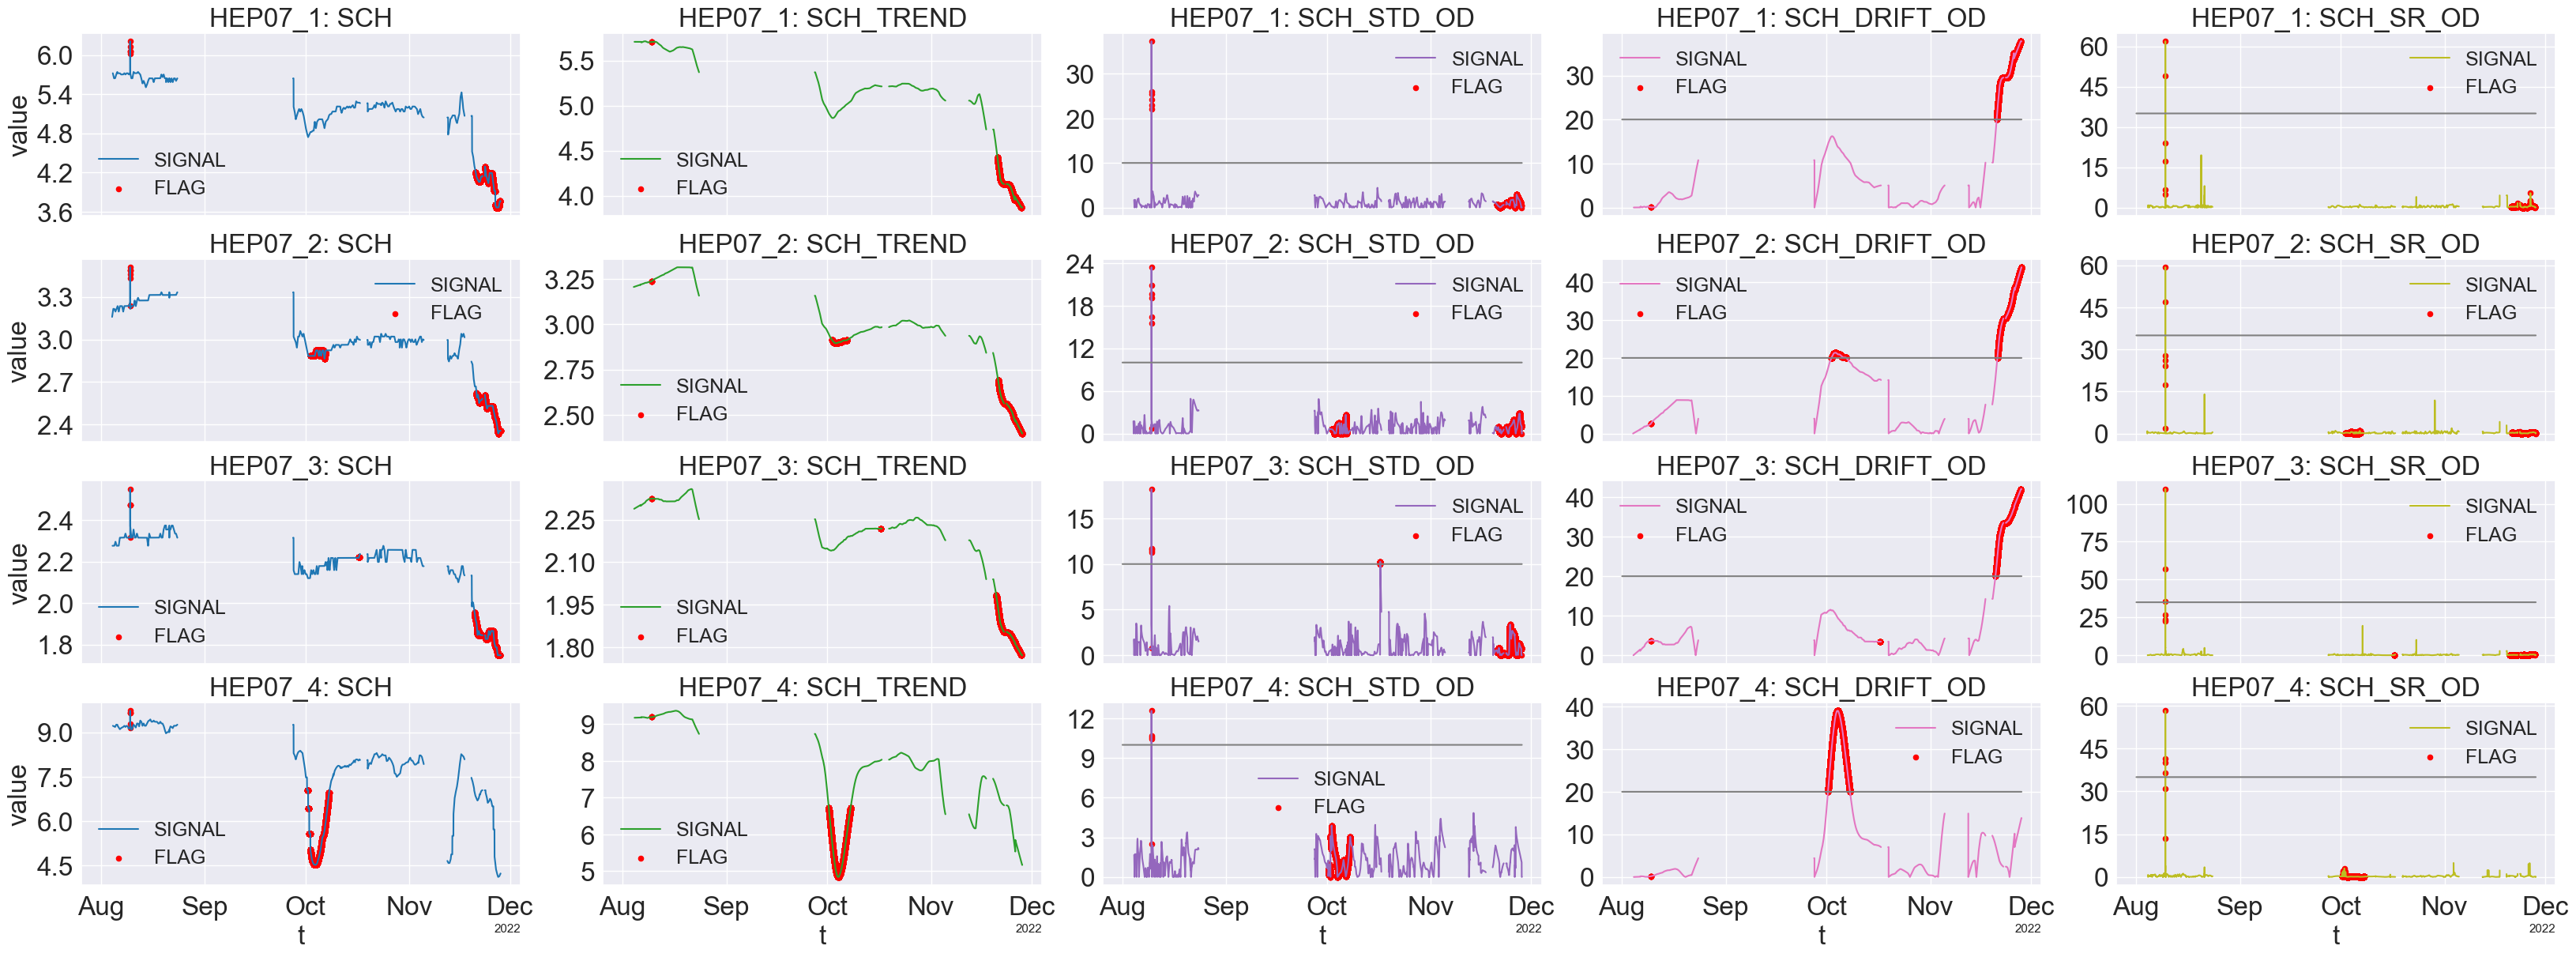

In [10]:
sel_sensor = "SCH"
fig = OnlineTSAD.plot_od_results_ts_with_markers(df_raw_hep07_rbx_rm_all, df_outlier_rm_hep07_rbx_rm_all, 
                                      system_col="RBX_RM", 
                                      sel_system=None, sel_sensor=sel_sensor,
                                      data_gap_dates=lhc_phy_run_dates,
                                      od_kwargs=od_kwargs)
util.save_figure(f"{datafilename}{DATASET}_{rbx_id}_od_{sel_sensor}_marked", fig,
                 filepath=fig_dirpath, isshow=True, issave=True, dpi=100)

plotting... may take few minutes depending on data size. Disable use_timestamp=False for further processing with index based x-axis.
saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//CMS_HCAL/causal_data/CMS_HCAL_HEP07_od_HEP07_1_marked.jpg


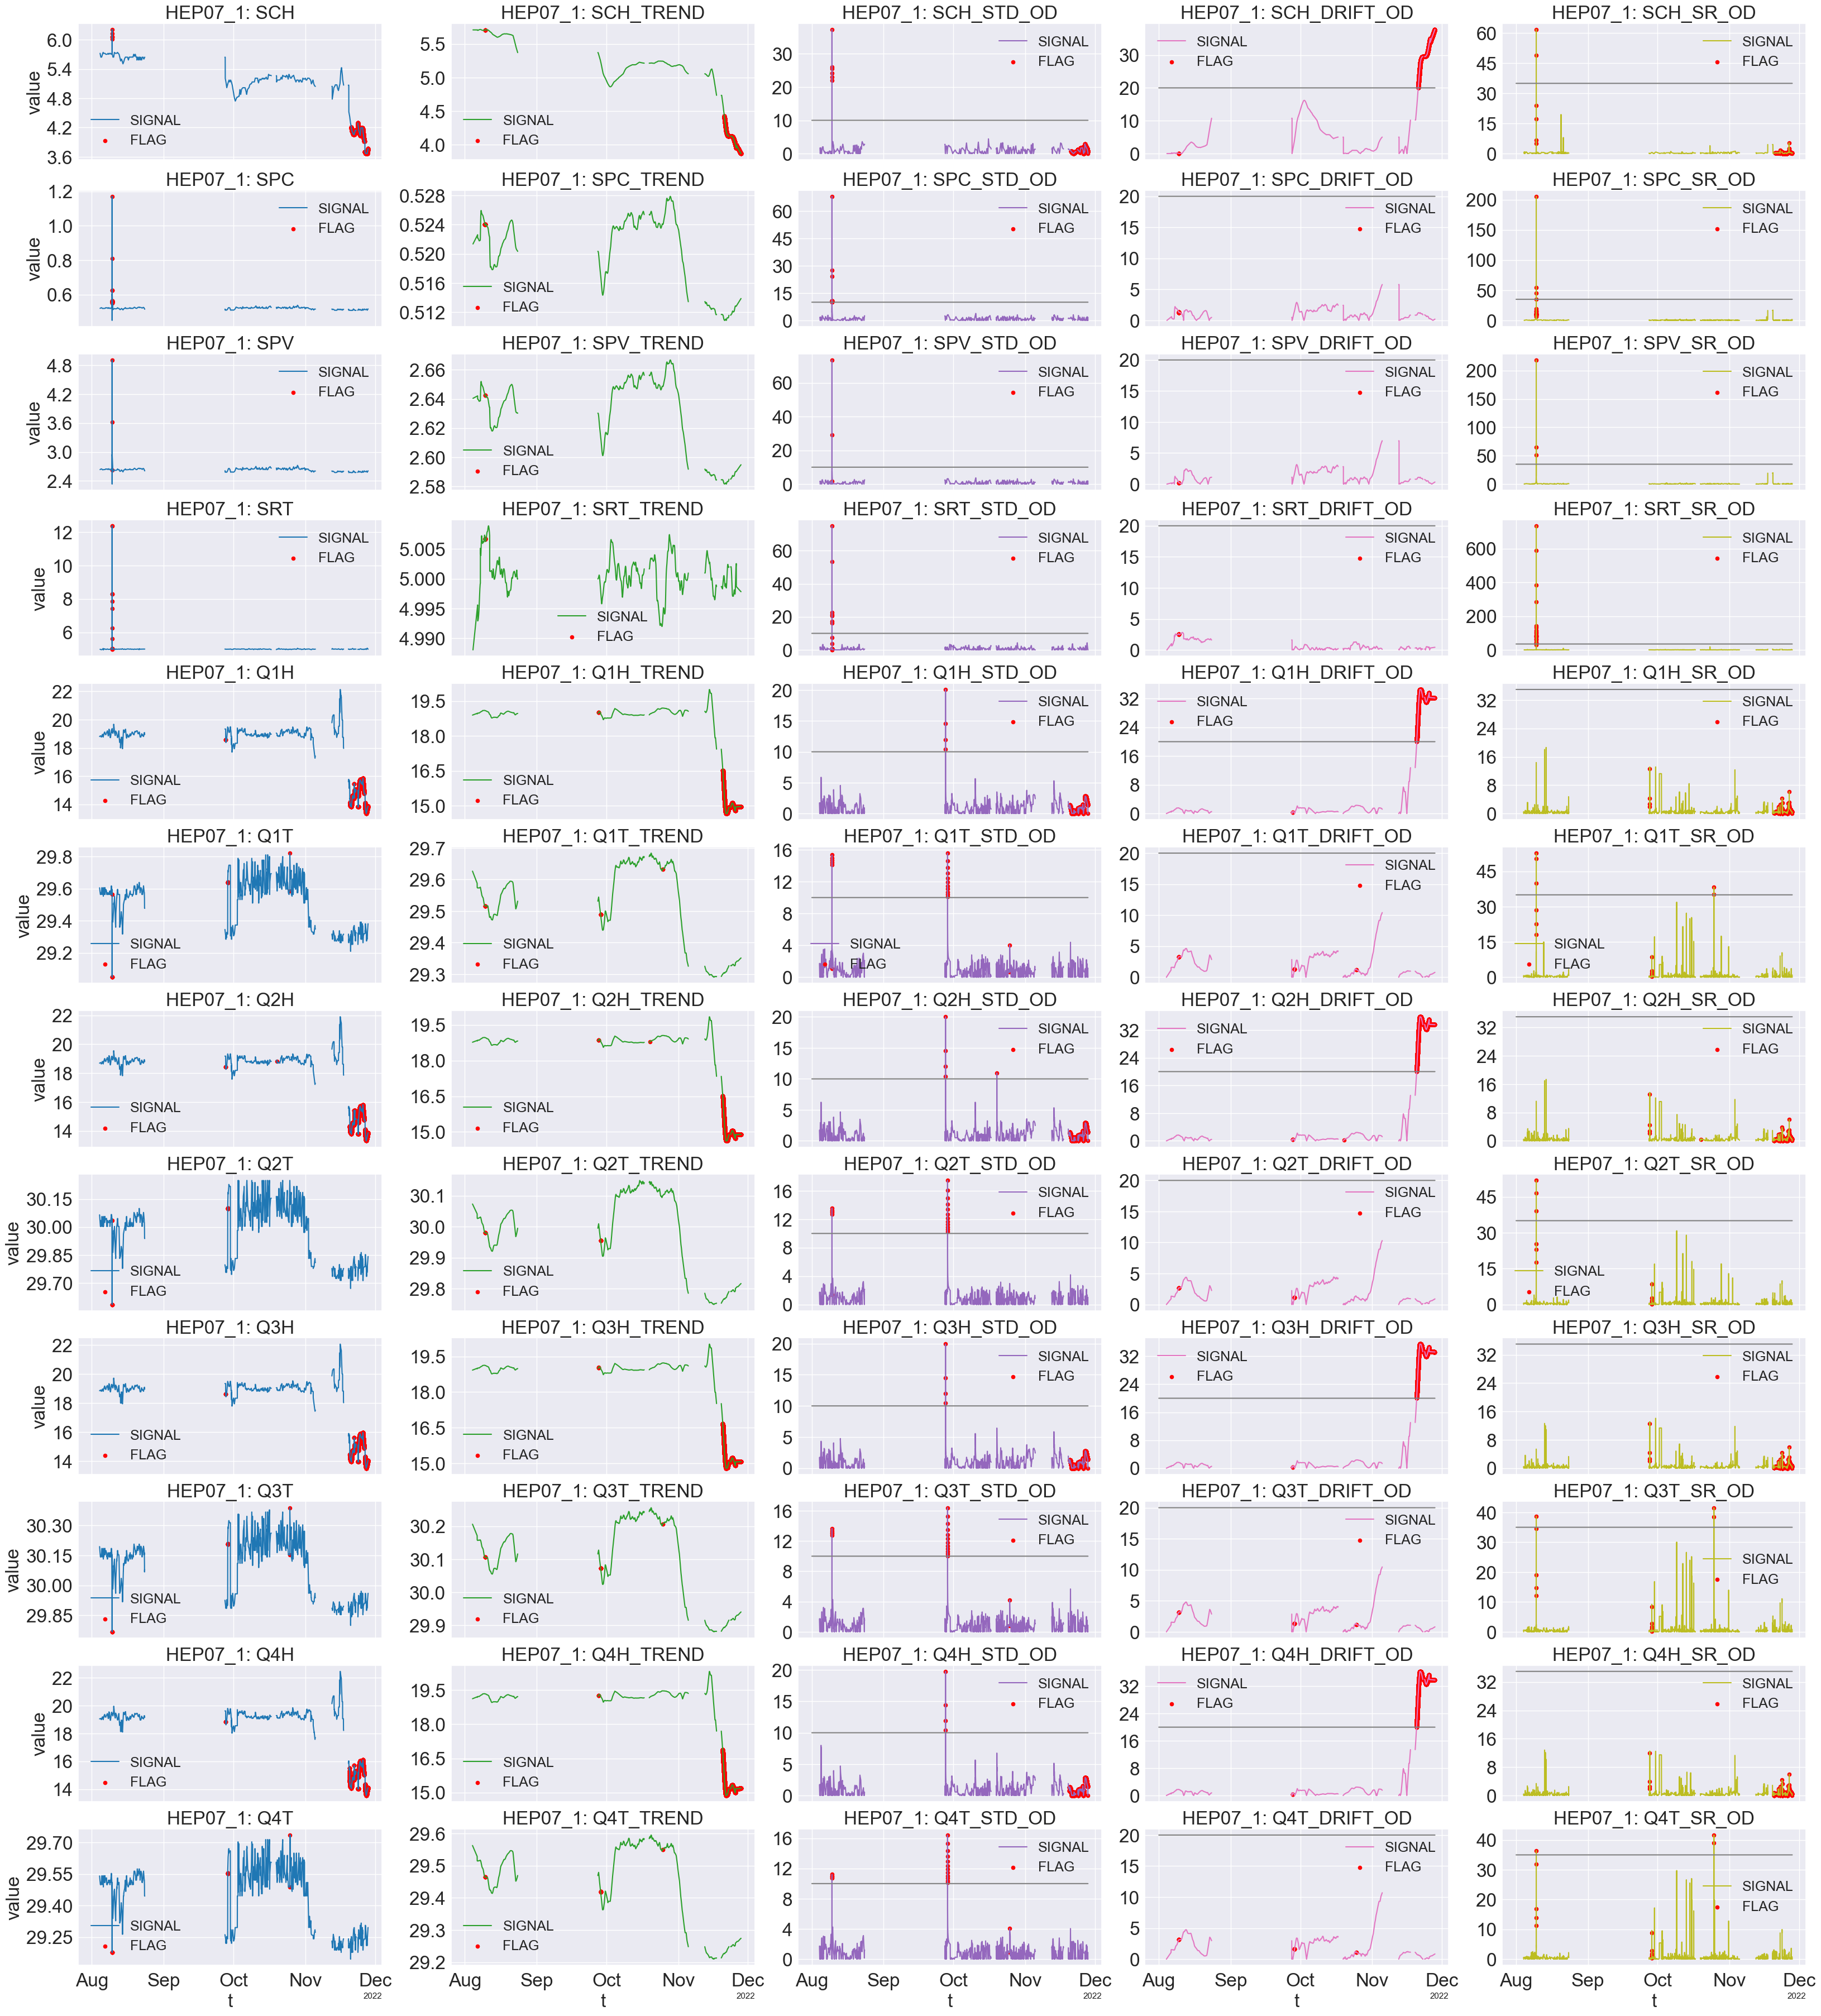

In [11]:
sel_system = "HEP07_1"
fig = OnlineTSAD.plot_od_results_ts_with_markers(df_raw_hep07_rbx_rm_all, df_outlier_rm_hep07_rbx_rm_all, 
                                      system_col="RBX_RM", 
                                      sel_system=sel_system, sel_sensor=None,
                                      data_gap_dates=lhc_phy_run_dates,
                                      od_kwargs=od_kwargs)
util.save_figure(f"{datafilename}{DATASET}_{rbx_id}_od_{sel_system}_marked", fig,
                 filepath=fig_dirpath, isshow=True, issave=True, dpi=100)

### Prepare Agg OD Flag Dataset

In [ ]:
df_aml = objODEngine.get_agg_multi_od_flags(df_raw_hep07_rbx_rm_all, df_outlier_rm_hep07_rbx_rm_all, ops_mask=None)
df_aml.shape
df_aml[df_raw_hep07_rbx_rm_all.loc[df_raw_hep07_rbx_rm_all["RBX_RM"]==rbx_rm_id].isna()] = np.nan
df_aml = df_aml.dropna(axis=0)
df_aml.reset_index(drop=True, inplace=True)
df_aml.shape

100%|██████████| 13/13 [00:00<00:00, 148.06it/s]


(399905, 12)

(381944, 12)

### Prepare and Store Binary Data

In [12]:
#  Save binary anomaly flag data
df_aml_rca = df_aml.copy()
df_aml_rca[df_aml_rca > 0] = 1
df_aml_rca.shape

util.save_csv(f"{datafilename}{DATASET}_{rbx_id}_od_binary_anomaly_flag_data.csv", df_aml_rca, filepath=fig_dirpath)

(381944, 12)

saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results///CMS_HCAL/causal_data/CMS_HCAL_HEP07_od_binary_anomaly_flag_data.csv
